# Using Data Science to understand the Hollywood Gender Gap

### Imports

In [484]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
import pandas as pd
from tqdm import tqdm
import math

In [4]:
import numpy as np

In [5]:
from subs2graph.consts import TEMP_PATH

## Introduction

In the past couple of years we have heard many stories about women discrimination is the film industry.
Even worse there was many reports of women sexual harassments in Hollywood which has led to the rise of the MeToo Movement.
This paper, investigates the gender gap in Hollywood utilizing data science techniques. 

## File Genartion

In [48]:
from subs2graph.videos_sn_creator import generate_actors_file
generate_actors_file()

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/dogpile/cache/util.py:31: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(fn)


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.principals.tsv.gz

Parsing completed. Parsed 100 lines in 1.15453 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int,str,str,str,list]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 1190442 lines. Lines per second: 842553

Read 9496862 lines. Lines per second: 1.44595e+06

Read 17696093 lines. Lines per second: 1.42837e+06

Read 24787792 lines. Lines per second: 1.40824e+06

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.principals.tsv.gz

Parsing completed. Parsed 30924394 lines in 22.0332 secs.

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 100 lines in 1.28029 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 686206 lines. Lines per second: 444927

Read 5697715 lines. Lines per second: 847489

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 8957228 lines in 9.8421 secs.

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.ratings.tsv.gz

Parsing completed. Parsed 100 lines in 0.355944 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.ratings.tsv.gz

Parsing completed. Parsed 883732 lines in 0.399085 secs.

AttributeError: 'IMDbDatasets' object has no attribute '_title'

## Analysis


<img src="https://i.kym-cdn.com/entries/icons/mobile/000/027/456/kowalski.jpg" />


In [9]:
from subs2graph.graph_analyzer import *

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/dogpile/cache/util.py:31: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(fn)


### Load actors-movies list

In [43]:
actors = pd.read_csv(f"{TEMP_PATH}/actors.csv",index_col=0 )
actors = actors.drop(["endYear", "isAdult", "knownForTitles", "originalTitle", "titleType"], axis=1)

In [44]:
len(actors["nconst"].unique())

1651

In [45]:
len(actors["tconst"].unique())

6712

In [46]:
len(actors[actors["gender"]=="F"]["nconst"].unique())

563

In [47]:
actors.head(1)

,averageRating,birthYear,count,deathYear,gender,genres,nconst,path,primaryName,primaryProfession,primaryTitle,runtimeMinutes,startYear,tconst
0,8.533333,1930,6,1987,F,"Comedy,Family,Romance",nm0621870,/Users/dimakagan/Projects/subs2graph/temp/movi...,Adile Nasit,actress,Sultan,88.0,1978.0,tt0264051


### Join with movies meta data

In [48]:
def analyze_actors():
    p = f"{TEMP_PATH}/movies/"
    res = []
    for i, a in tqdm(actors.iterrows()):
        g_pth = a["path"]
        try:
            with open(glob.glob(os.path.join(f"{g_pth}/json", f"*roles*"))[0]) as f:
                g = json_graph.node_link_graph(json.load(f))
                if g.number_of_nodes() < 6:
                    continue
                d = get_actor_features(g, a["primaryName"])
            res.append({**d, **a})
        except KeyError:
            pass

    return res

In [49]:
actors_features =  pd.DataFrame(analyze_actors())

16664it [01:34, 175.61it/s]


In [50]:
actors_features = actors_features.drop("count", axis=1)

In [51]:
len(actors_features)

11133

In [52]:
actors_features = actors_features.sort_values("nconst")

### Feature Engineering 

Graph based:

In [53]:
graph_features = ["betweenness", "closeness", 'clustering','degree', 'degree_centrality','total_weight']

Date based features:

In [54]:
actors_features = actors_features.replace("\\N", 0)
actors_features = actors_features.dropna()
actors_features["deathYear"] = actors_features["deathYear"].astype(int)
actors_features["birthYear"] = actors_features["birthYear"].astype(int)
actors_features["startYear"] = actors_features["startYear"].astype(int)
actors_features["age_filming"] = actors_features["startYear"] - actors_features["birthYear"]

In [55]:
actors_features = actors_features[actors_features["birthYear"]!=0]

Multiple categories to onehot

In [56]:
# actors_features["primaryProfession"] = actors_features["primaryProfession"].apply(lambda x: x.split(","))
actors_features["genres"] = actors_features["genres"].apply(lambda x: x.split(","))

In [57]:
genres = set()
for genre in set().union(*actors_features.genres.values):
    actors_features[genre] = actors_features.apply(lambda _: int(genre in _.genres), axis=1)
    genres.add(genre)
    
# for prof in set().union(*actors_features.primaryProfession.values):
#     actors_features[prof] = actors_features.apply(lambda _: int(prof in _.primaryProfession), axis=1)

Gender to numeric - Male=1 Female=0

In [21]:
actors_features["gender_num"] = actors_features["gender"].apply(lambda x: 1 if x == "M" else 0)

### ML

In [23]:
df = actors_features.drop(["gender","genres","path","primaryName","primaryProfession","primaryTitle", "tconst"], axis=1)

In [24]:
male =  df[df["gender_num"]==1]
female = df[df["gender_num"]==0]

In [124]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

In [125]:
def rmse(x, y): return math.sqrt(((x-y)**2).mean())
 

def print_score(m, X_train, y_train, X_valid, y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

Imbalanced Dataset:

In [27]:
len(actors_features[actors_features["gender"]=="M"])

7423

In [28]:
len(actors_features[actors_features["gender"]=="F"])

3695

In [29]:

# balanced_df = male.sample(len(female)).append(female)
# balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [30]:
male_sample = male.sort_values("nconst")[:len(female)]
n_valid = 2000
male_sample = male_sample.drop(["nconst", "gender_num"], axis=1)
female_sample = female.drop(["nconst", "gender_num"], axis=1)
male_train, male_valid = split_vals(male_sample, n_valid//2)
female_train, female_valid = split_vals(female_sample, n_valid//2)

In [31]:
X_train = male_train.append(female_train)
X_valid = male_valid.append(female_valid)
y_train = np.concatenate((np.ones(len(male_train)), np.zeros(len(female_train))))
y_valid = np.concatenate((np.ones(len(male_valid)), np.zeros(len(female_valid))))

In [32]:
# y = balanced_df.pop("gender_num")
# n_valid = 2000  # same as Kaggle's test set size
# n_trn = len(balanced_df)-n_valid
# X_train, X_valid = split_vals(balanced_df, n_trn)
# y_train, y_valid = split_vals(y, n_trn)

In [33]:
# balanced_df.to_csv("../mf_balanced.csv", index=False)
# balanced_df[graph_features+["gender_num"]].to_csv("../mf_balanced_graph.csv", index=False)
# balanced_df.drop(graph_features, axis=1).to_csv("../mf_balanced_not_graph.csv", index=False)

In [130]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn import metrics

In [35]:
m = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=100)
m.fit(X_train[graph_features], y_train)
print_score(m, X_train[graph_features], y_train, X_valid[graph_features], y_valid)

[0.05477225575051661, 0.6862011258790672, 0.997, 0.5291280148423005]


In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid[graph_features])[:, 1])

0.5430856289218335

In [37]:
other_features = list(set(X_train.columns.values) - set(graph_features))
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train[other_features], y_train)
print_score(m, X_train[other_features], y_train, X_valid[other_features], y_valid)

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.07745966692414834, 0.6293678543617366, 0.994, 0.6038961038961039]


all

In [38]:
best_features = X_train.columns.values

In [39]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=50, max_features=0.5 , min_samples_split=5, min_samples_leaf=25)
m.fit(X_train[best_features], y_train)
print_score(m, X_train[best_features], y_train, X_valid[best_features], y_valid)

[0.3840572873934304, 0.609449400220044, 0.8525, 0.6285714285714286]


In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid[best_features])[:, 1])

0.7363135195046141

What is important?

In [43]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index=best_features,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
averageRating,0.374913
birthYear,0.317225
age_filming,0.110031
betweenness,0.036811
pagerank,0.036181
startYear,0.020640
clustering,0.018146
total_weight,0.015393
deathYear,0.012377
degree_centrality,0.011766


In [777]:
best_features = list(feature_importances[feature_importances["importance"] > 0].index)

In [44]:
male_sample = male.sort_values("nconst")[:len(female)]
leave_one_data = male_sample.append(female)
leave_one_data = leave_one_data.sort_values("nconst")

groups = leave_one_data.nconst.astype("category").cat.codes
y = leave_one_data.pop("gender_num")
X = leave_one_data.drop(["nconst"], axis=1)


In [45]:
from sklearn.model_selection import LeaveOneGroupOut

# X = [1, 5, 10, 50, 60, 70, 80]
# y = [0, 1, 1, 2, 2, 2, 2]
# groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
loo_split = logo.split(X, y, groups=groups)
# count = 0
# for train, test in loo_split:
#     print("%s %s" % (train, test))
#     if count == 5:
#         break
#     count += 1

In [803]:
from sklearn.metrics import confusion_matrix
# A sample toy binary classification dataset
from sklearn.metrics import make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

In [807]:
from sklearn import model_selection
scoring = ['accuracy', 'precision', 'recall']
model = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=50)
results = model_selection.cross_validate(model, X[, y, cv=loo_split, scoring=scoring)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due 

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to 

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


AttributeError: 'DeprecationDict' object has no attribute 'mean'

In [46]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score

In [47]:
def get_classification_metrics(l_test, prediction, probas):
    # fpr, tpr, thresholds = roc_curve(l_test, prediction)
    false_positive = float(
        len(np.where(l_test - prediction == -1)[0]))  # 0 (truth) - 1 (prediction) == -1 which is a false positive
    true_negative = float(
        len(np.where(l_test + prediction == 0)[0]))  # 0 (truth) - 0 (prediction) == 0 which is a true positive
    return {"auc": roc_auc_score(l_test, probas),
            "recall": recall_score(l_test, prediction),
            "precision": precision_score(l_test, prediction),
            "accuracy": accuracy_score(l_test, prediction),
            "fpr": false_positive / (true_negative + false_positive),
            "tnr": true_negative / (true_negative + false_positive)
            }

In [48]:
def cross_validate(X, y):
    # clf = SkLearner(clone(self._classifier), self._label_encoder)
    roc_auc, recall, precision, accuracy, fpr, tpr, tnr = [], [], [], [], [], [], []
    all_probas =[]
    for train_index, test_index in loo_split:
        f_train, f_test = X.iloc[train_index], X.iloc[test_index]
        l_train, l_test = y.iloc[train_index], y.iloc[test_index]
        # prediction = self.train_classifier(DataSet(f_train, l_train)).predict(f_test)
        clf = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=100)
        clf.fit(f_train, l_train)
        probas = clf.predict_proba(f_test)[:, 1]
        all_probas.append(probas)
    # return {"auc": np.mean(roc_auc)}
    # print classification_report(l_test, prediction)
    # print "Predicted: 0   1"
    # print confusion_matrix(l_test, prediction)
    return all_probas
#     return {"auc": np.mean(roc_auc), "recall": np.mean(recall), "precision": np.mean(precision),
#             "accuracy": np.mean(accuracy), "fpr": np.mean(fpr), "tnr": np.mean(tnr)}

In [49]:
res = cross_validate(X,y)

In [50]:
res_p = np.concatenate(res)

In [51]:
prediction = np.where(res_p > 0.5, 1, 0)

In [52]:
len(res_p)

7390

In [53]:
get_classification_metrics(y,prediction ,res_p)

{'auc': 0.8005875987189653,
 'recall': 0.7309878213802435,
 'precision': 0.7183510638297872,
 'accuracy': 0.722192151556157,
 'fpr': 0.2866035182679296,
 'tnr': 0.7133964817320704}

### Statistics

#### Males

In [120]:
male.describe().T

,count,mean,std,min,25%,50%,75%,max
averageRating,8205.0,6.563888,0.454584,3.850000,6.300000,6.573333,6.826316,8.335294
betweenness,8205.0,0.198978,0.245966,0.000000,0.000952,0.093939,0.316919,1.000000
birthYear,8205.0,1957.041316,51.802972,-1.000000,1948.000000,1961.000000,1971.000000,2006.000000
closeness,8205.0,0.740588,0.184065,0.050000,0.600000,0.750000,0.888889,1.000000
clustering,8205.0,0.500291,0.323257,0.000000,0.266667,0.500000,0.733333,1.000000
count,8205.0,21.944546,13.798410,6.000000,10.000000,19.000000,30.000000,75.000000
deathYear,8205.0,214.999147,620.872866,-1.000000,-1.000000,-1.000000,-1.000000,2018.000000
degree,8205.0,7.099939,5.177353,1.000000,3.000000,6.000000,10.000000,56.000000
degree_centrality,8205.0,0.633667,0.288870,0.011765,0.400000,0.666667,0.875000,3.000000
runtimeMinutes,8205.0,111.824254,21.276988,63.000000,97.000000,108.000000,122.000000,325.000000


#### Feamles

In [121]:
female.describe().T

,count,mean,std,min,25%,50%,75%,max
averageRating,4024.0,6.471860,0.433752,4.366667,6.191667,6.490909,6.745455,8.183333
betweenness,4024.0,0.135879,0.195969,0.000000,0.000000,0.047619,0.194633,1.000000
birthYear,4024.0,1967.932406,15.896943,1893.000000,1960.000000,1970.000000,1979.000000,1998.000000
closeness,4024.0,0.716796,0.172747,0.050000,0.600000,0.714286,0.844351,1.000000
clustering,4024.0,0.569591,0.314961,0.000000,0.333333,0.600000,0.833333,1.000000
count,4024.0,17.341700,9.361723,6.000000,10.000000,15.000000,23.000000,47.000000
deathYear,4024.0,74.147614,380.640019,-1.000000,-1.000000,-1.000000,-1.000000,2018.000000
degree,4024.0,6.622515,4.636249,1.000000,3.000000,6.000000,9.000000,41.000000
degree_centrality,4024.0,0.591365,0.273972,0.040000,0.368421,0.600000,0.818182,1.500000
runtimeMinutes,4024.0,110.025099,18.573516,75.000000,97.000000,106.000000,119.000000,242.000000


#### Gender Gap

In [54]:
df = actors_features.drop(["genres","nconst","path","primaryName","primaryProfession","primaryTitle", "tconst"], axis=1)

In [55]:
pd.pivot_table(df[df["startYear"] > 1990], index=["Western","gender"]).T

Western                      0                         1             
gender                       F            M            F            M
Action                0.182409     0.295271     0.214286     0.235294
Adventure             0.141530     0.207942     0.071429     0.294118
Animation             0.027563     0.040863     0.000000     0.000000
Biography             0.068752     0.073323     0.000000     0.000000
Comedy                0.450294     0.402702     0.142857     0.235294
Crime                 0.179932     0.257538     0.071429     0.058824
Documentary           0.000000     0.000000     0.000000     0.000000
Drama                 0.584082     0.529906     0.500000     0.500000
Family                0.066584     0.050914     0.000000     0.000000
Fantasy               0.084546     0.078596     0.000000     0.058824
Film-Noir             0.000000     0.000000     0.000000     0.000000
History               0.024156     0.034273     0.000000     0.000000
Horror                0.083927     0.064426     0.000000     0.000000
Music                 0.030660     0.022244     0.000000     0.000000
Musical               0.012697     0.007250     0.000000     0.000000
Mystery               0.109631     0.096227     0.000000     0.000000
Romance               0.275008     0.163948     0.428571     0.058824
Sci-Fi                0.065655     0.079090     0.000000     0.000000
Sport                 0.015794     0.030153     0.000000     0.000000
Thriller              0.152989     0.177624     0.000000     0.000000
War                   0.008671     0.014829     0.000000     0.000000
age_filming          35.560235    42.888614    33.857143    45.911765
averageRating         6.429909     6.509045     6.506972     6.525813
betweenness           0.133560     0.193686     0.113771     0.155031
birthYear          1971.016414  1963.251442  1970.142857  1961.882353
closeness             0.704023     0.728114     0.714055     0.702734
clustering            0.576004     0.510741     0.661590     0.508060
deathYear            15.572313    82.198385     0.000000    58.882353
degree                7.051099     7.733070     8.142857     9.294118
degree_centrality     0.570149     0.613389     0.599500     0.588144
gender_num            0.000000     1.000000     0.000000     1.000000
movie_rating          6.470022     6.550486     6.314286     6.747059
pagerank              0.136199     0.159328     0.120245     0.141688
runtimeMinutes      110.029421   111.845609   120.214286   120.588235
startYear          2006.576649  2006.140056  2004.000000  2007.794118
total_weight        142.452772   174.823200   101.857143   164.205882

In [56]:
temp_df = pd.DataFrame()
res = []
for g in genres:
    res.append(pd.pivot_table(df, index=[g,"gender"], aggfunc=np.mean).drop(list(genres - {g}),axis=1))

In [57]:
genre_age_gap = pd.concat(res, axis=1, sort=False, keys=list(genres)).T[1]

In [58]:
genre_age_gap["gap"] = genre_age_gap["M"] - genre_age_gap["F"]

In [59]:
genre_age_gap

F            M         gap
Documentary age_filming                NaN    40.333333         NaN
            averageRating              NaN     6.962500         NaN
            betweenness                NaN     0.044444         NaN
            birthYear                  NaN  1941.666667         NaN
            closeness                  NaN     0.904762         NaN
            clustering                 NaN     0.866667         NaN
            deathYear                  NaN     0.000000         NaN
            degree                     NaN     4.333333         NaN
            degree_centrality          NaN     0.866667         NaN
            gender_num                 NaN     1.000000         NaN
            movie_rating               NaN     7.900000         NaN
            pagerank                   NaN     0.164411         NaN
            runtimeMinutes             NaN    77.000000         NaN
            startYear                  NaN  1982.000000         NaN
            total_weight               NaN    54.666667         NaN
Fantasy     age_filming          34.160131    41.115385    6.955254
            averageRating         6.484159     6.510912    0.026752
            betweenness           0.131721     0.206898    0.075177
            birthYear          1969.686275  1962.181319   -7.504956
            closeness             0.695267     0.726280    0.031013
            clustering            0.583679     0.518285   -0.065395
            deathYear            32.898693   117.452381   84.553688
            degree                6.395425     7.144689    0.749264
            degree_centrality     0.561656     0.608519    0.046863
            gender_num            0.000000     1.000000    1.000000
            movie_rating          6.435621     6.382967   -0.052654
            pagerank              0.139131     0.166226    0.027095
            runtimeMinutes      112.078431   113.212454    1.134023
            startYear          2003.846405  2003.296703   -0.549702
            total_weight        131.343137   160.377289   29.034152
...                                    ...          ...         ...
Film-Noir   age_filming          32.916667    38.363636    5.446970
            averageRating         7.562556     7.439949   -0.122607
            betweenness           0.147972     0.205101    0.057130
            birthYear          1915.083333  1910.484848   -4.598485
            closeness             0.845388     0.866861    0.021472
            clustering            0.748479     0.624385   -0.124094
            deathYear          1996.333333  1865.727273 -130.606061
            degree                6.000000     6.848485    0.848485
            degree_centrality     0.789616     0.808165    0.018549
            gender_num            0.000000     1.000000    1.000000
            movie_rating          7.850000     7.993939    0.143939
            pagerank              0.171593     0.201075    0.029482
            runtimeMinutes      100.083333    98.939394   -1.143939
            startYear          1948.000000  1948.848485    0.848485
            total_weight        199.333333   300.424242  101.090909
Western     age_filming          34.434783    44.191011    9.756229
            averageRating         6.808839     6.866602    0.057762
            betweenness           0.099886     0.159284    0.059398
            birthYear          1953.304348  1937.123596  -16.180752
            closeness             0.725523     0.736332    0.010809
            clustering            0.657854     0.513244   -0.144610
            deathYear           611.391304   848.719101  237.327797
            degree                8.130435     8.471910    0.341475
            degree_centrality     0.604823     0.626639    0.021816
            gender_num            0.000000     1.000000    1.000000
            movie_rating          6.773913     7.206742    0.432829
            pagerank              0.122784     0.145135    0.022350
            runtimeMinutes   

In [847]:
genre_age_gap.loc["Animation"]

,F,M,gap
age_filming,38.016807,46.079872,8.063065
animation_department,0.000000,0.003195,0.003195
art_department,0.000000,0.000000,0.000000
assistant_director,0.000000,0.000000,0.000000
averageRating,6.397867,6.475881,0.078014
betweenness,0.123826,0.147507,0.023682
birthYear,1968.764706,1960.945687,-7.819019
camera_department,0.008403,0.000000,-0.008403
casting_department,0.000000,0.000000,0.000000
casting_director,0.000000,0.000000,0.000000


In [60]:
# pivot = pd.pivot_table(df, index=["gender"],
#                      aggfunc=[min, np.median, max, np.mean]).T

In [73]:
id_vars = list(set( df.columns.values) - set(genres))
df_chart = pd.melt(df, id_vars=id_vars, value_vars=genres)

In [74]:
df_chart = df_chart[df_chart["value"]!=0]

In [75]:
df_chart = df_chart.rename(columns={"variable":"genere"})

In [77]:
df_chart = df_chart.drop(["value", "gender_num"],axis=1)

In [79]:
id_vars.remove("gender_num")

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


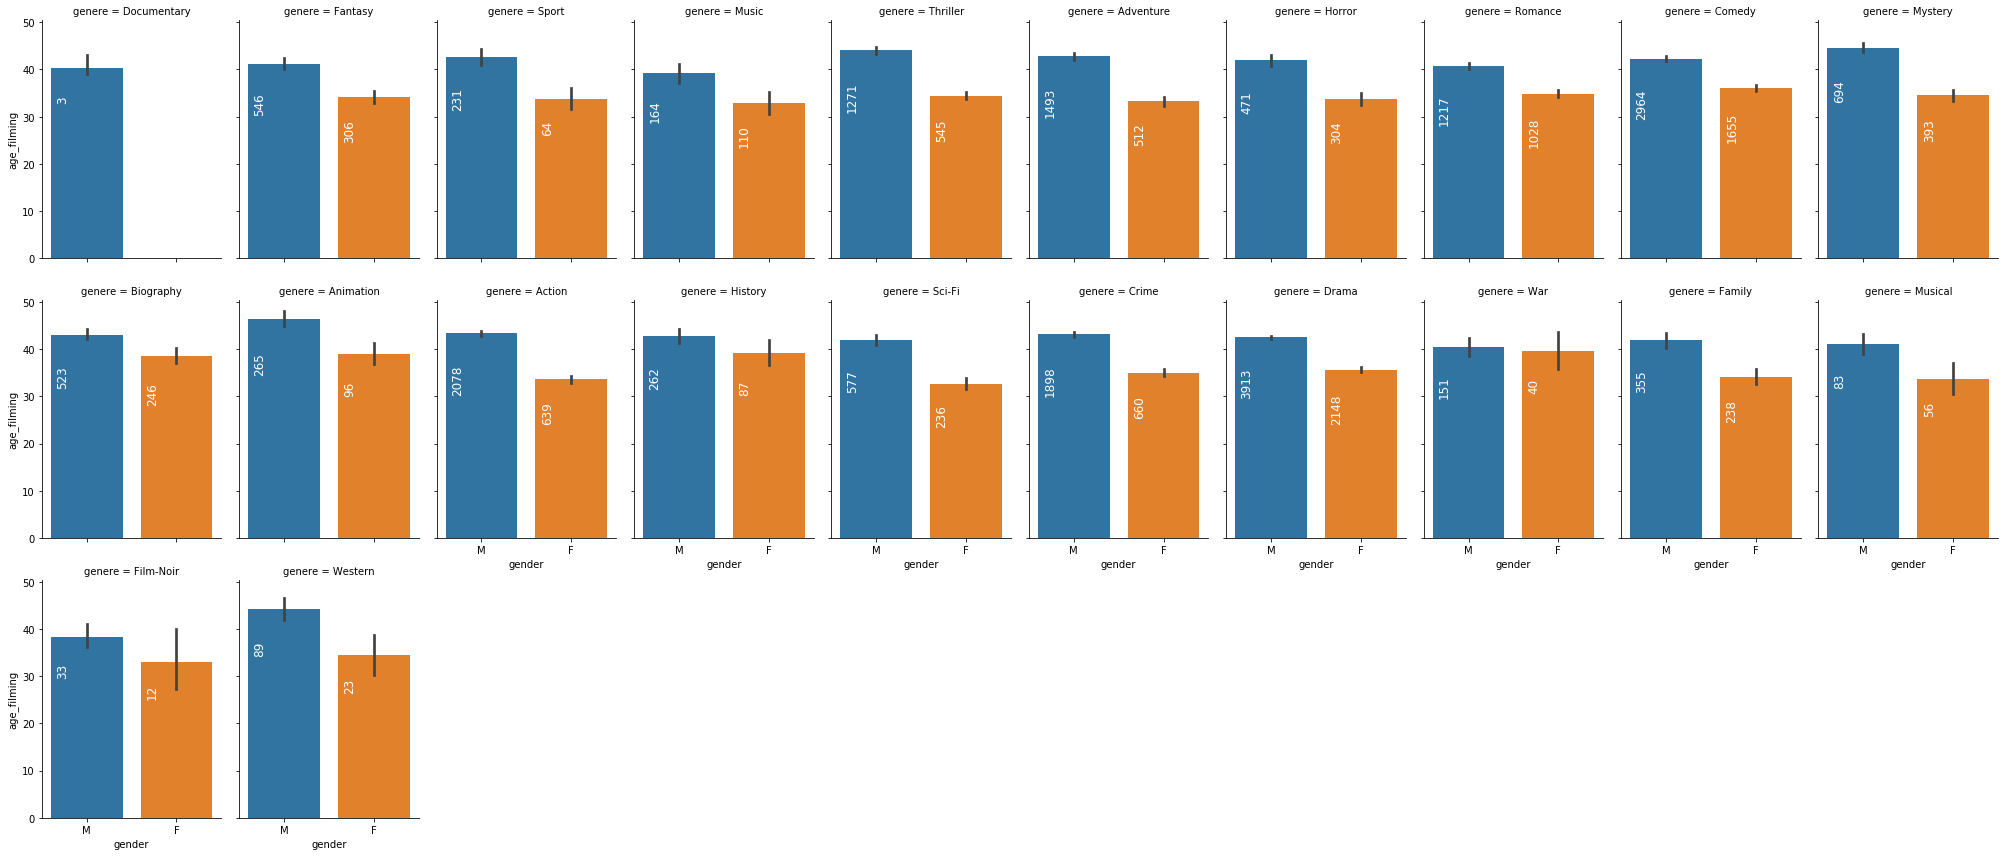

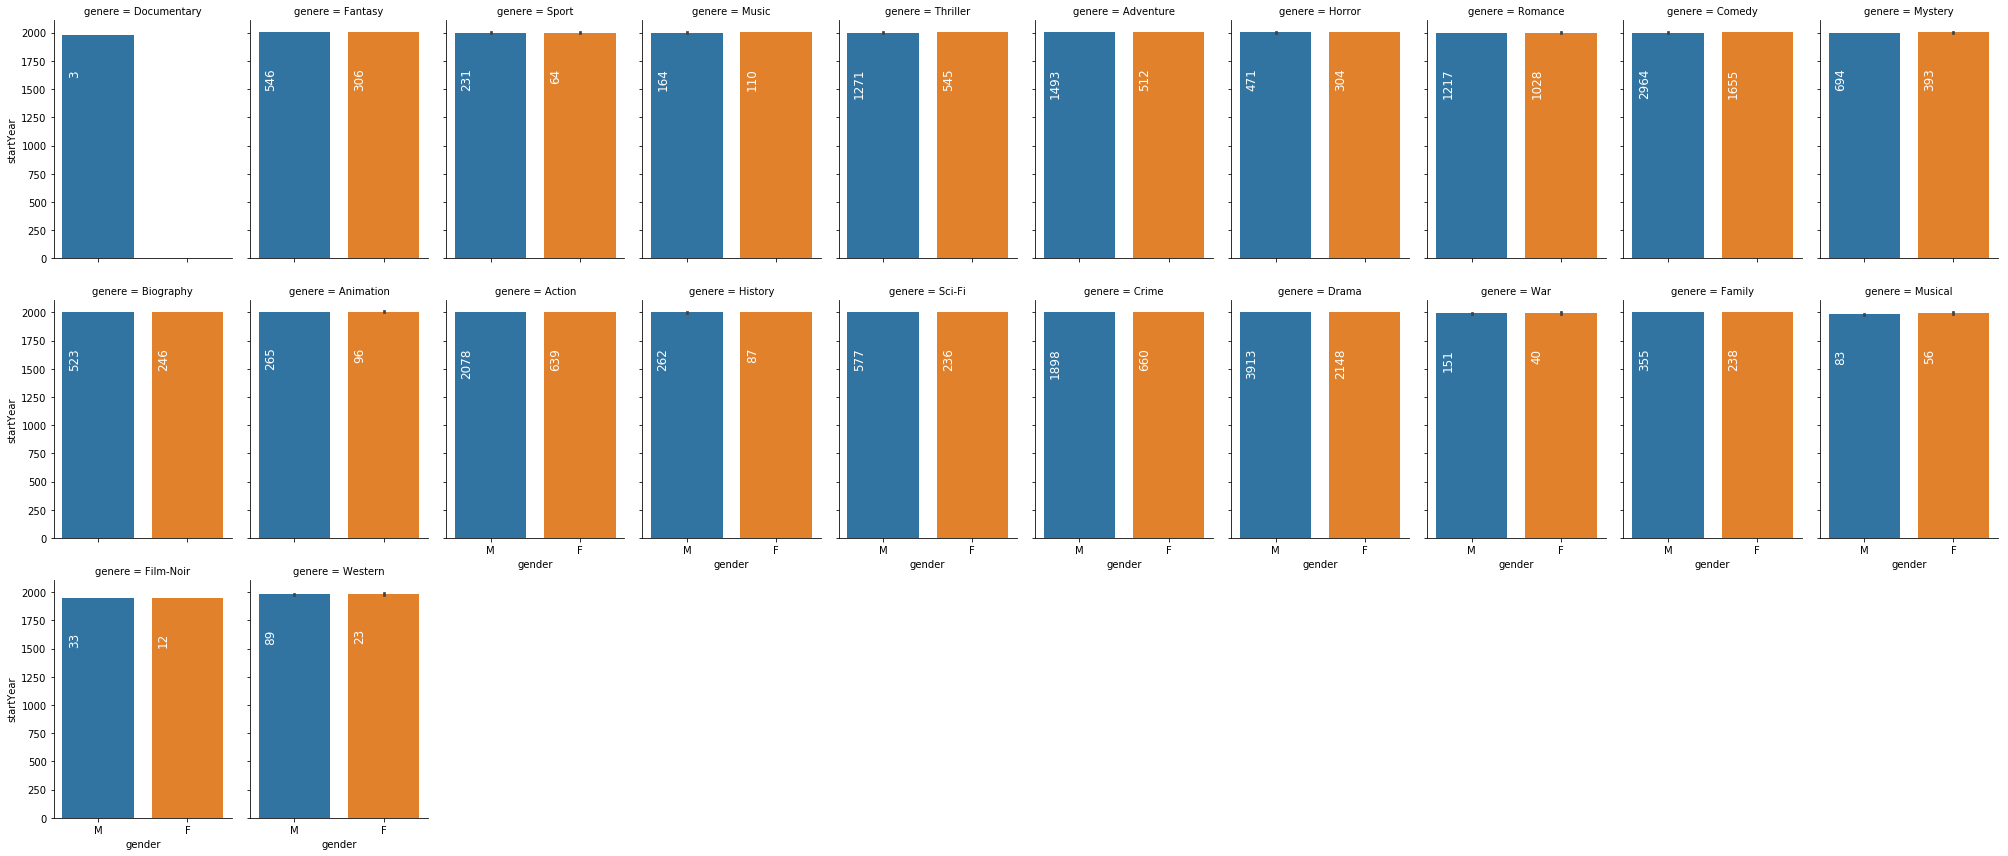

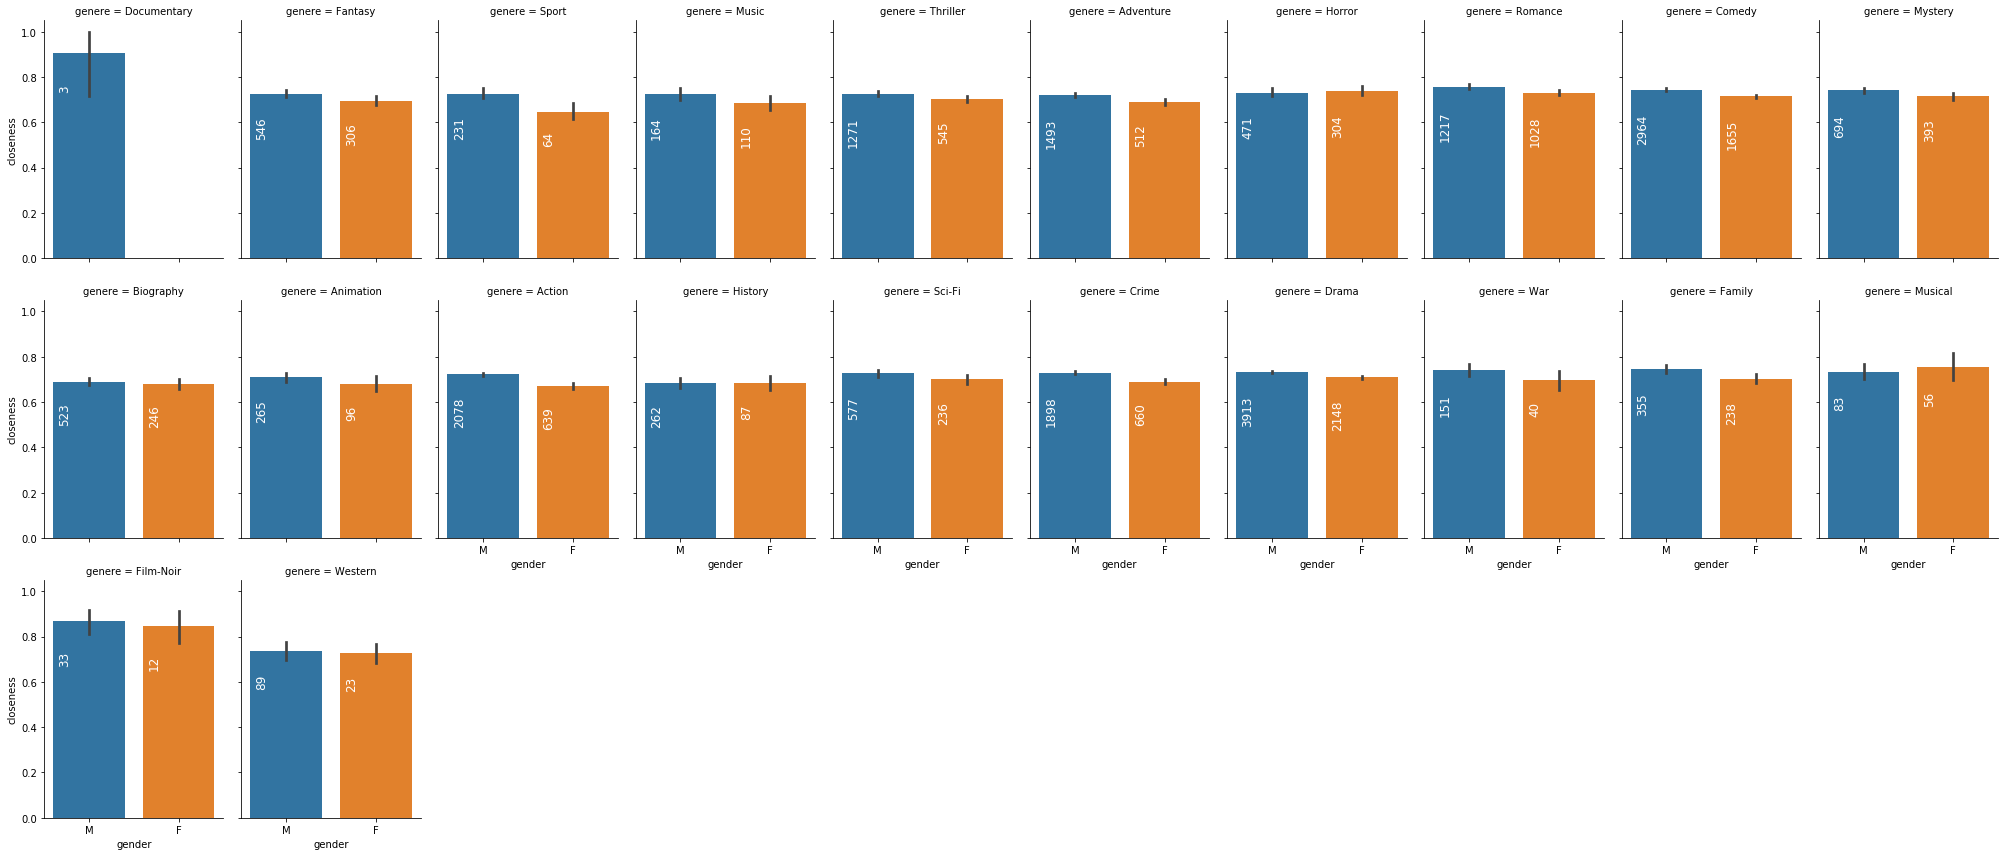

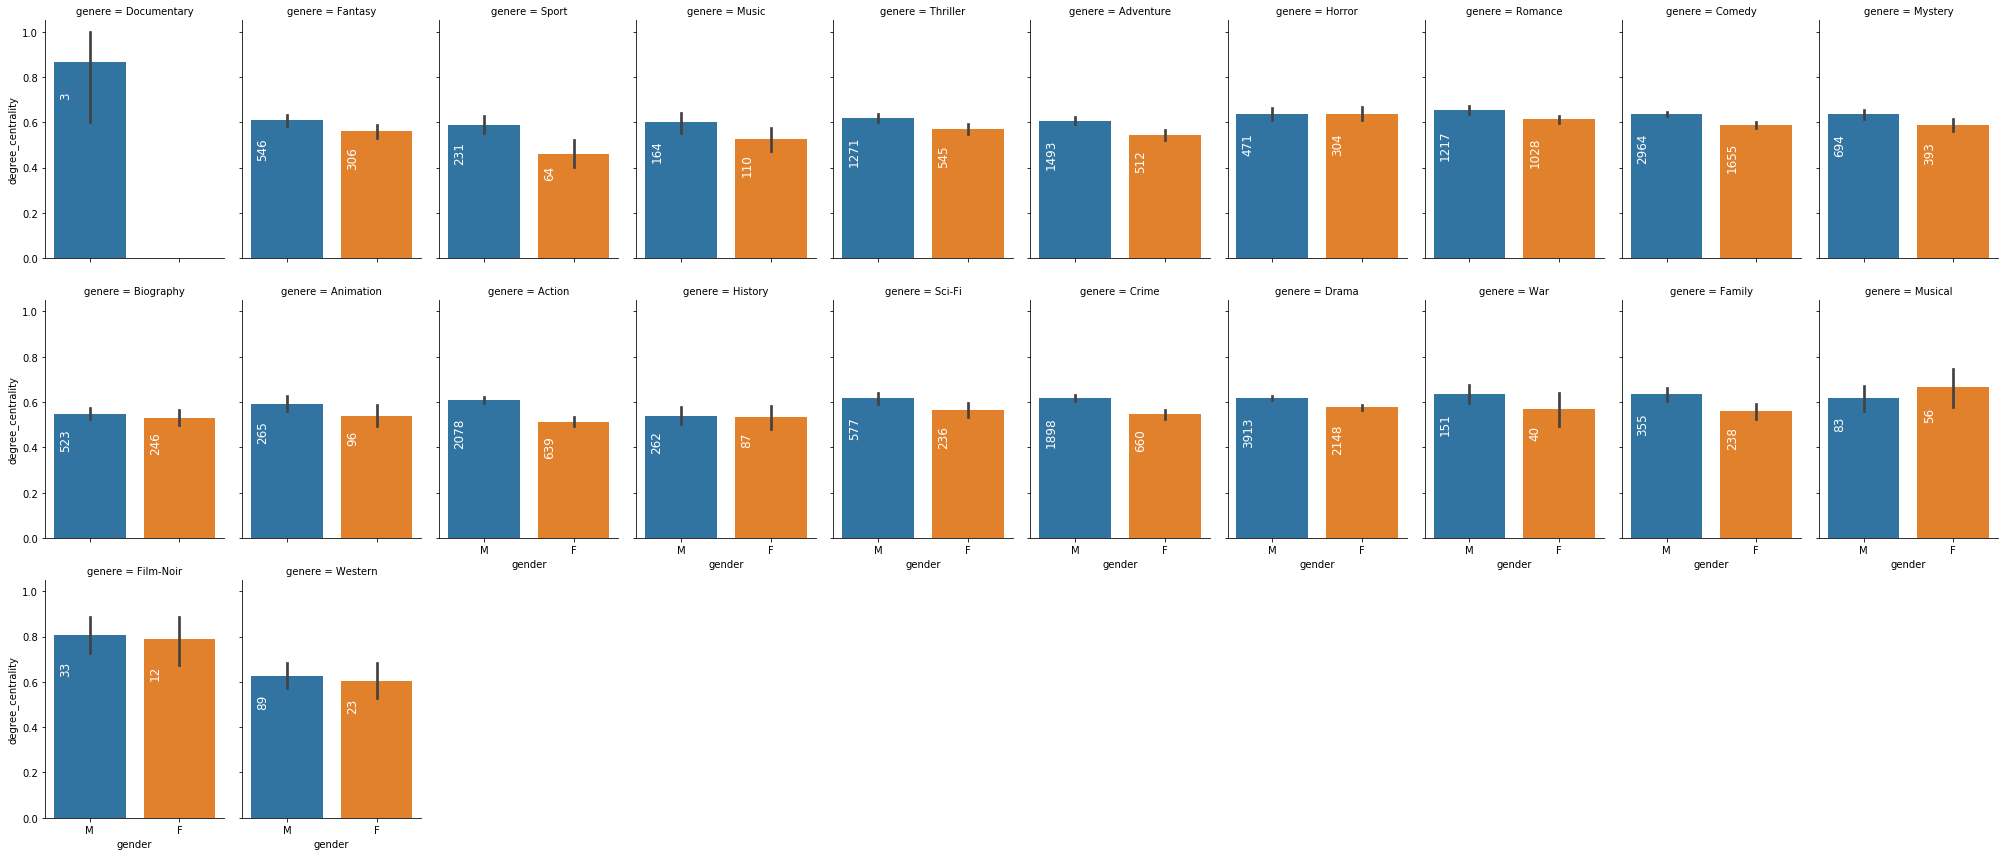

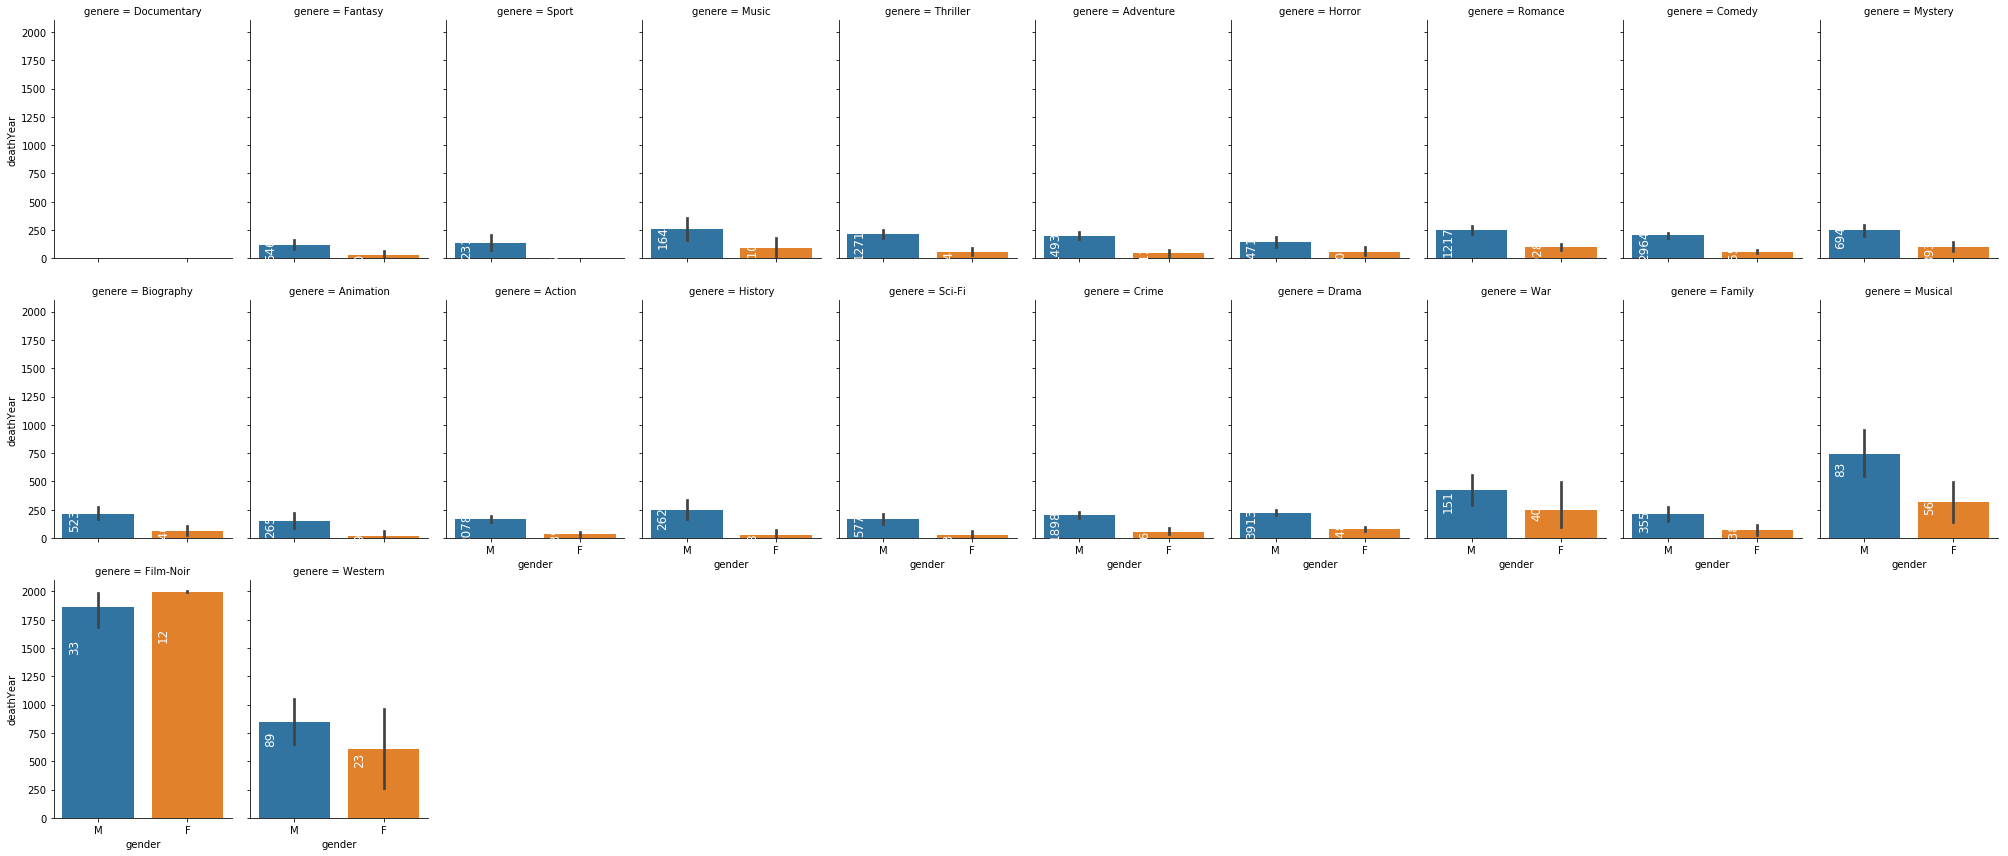

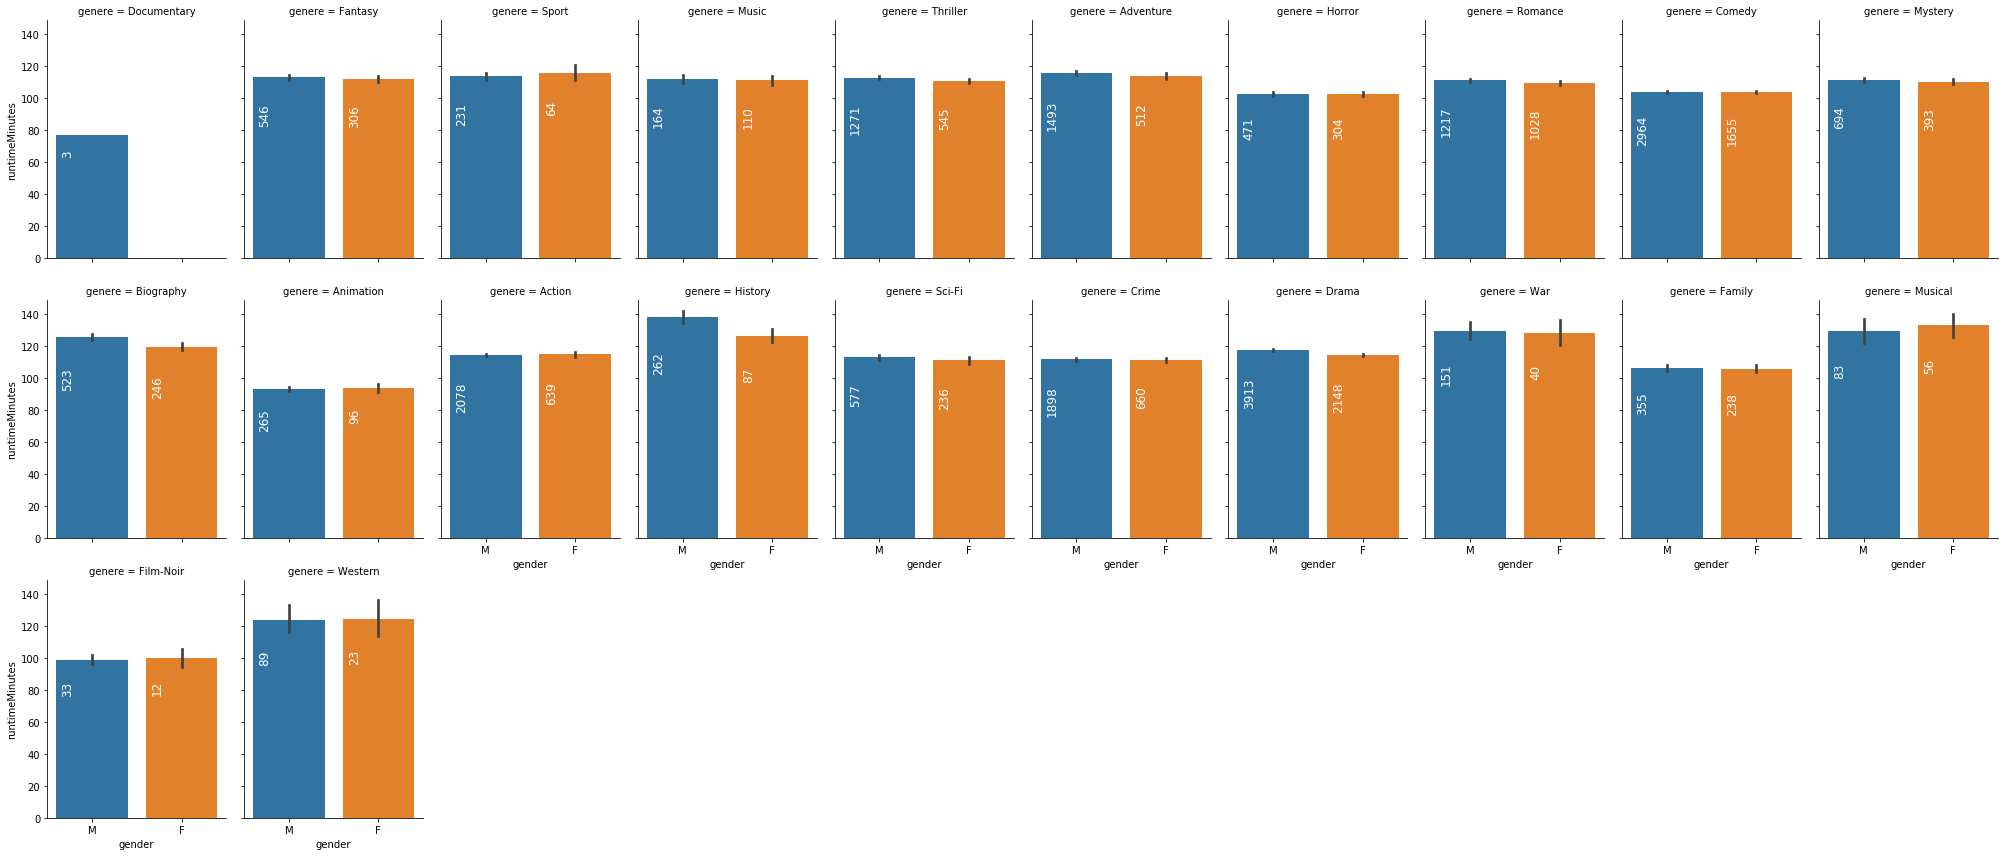

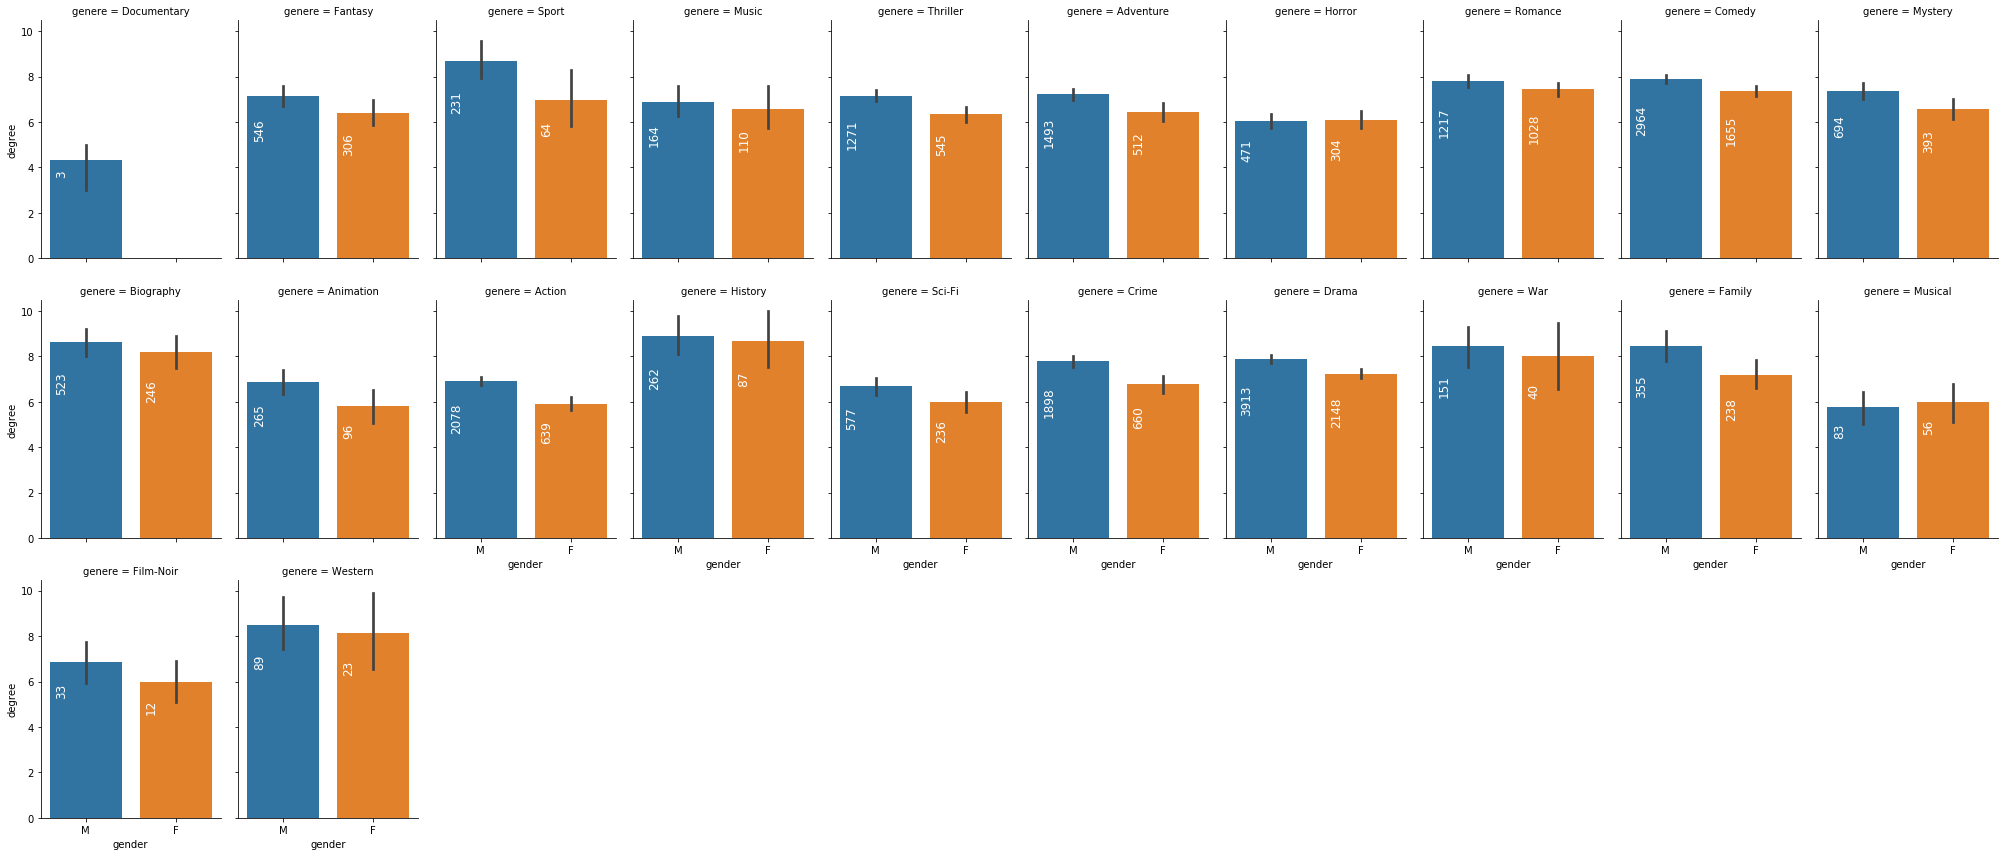

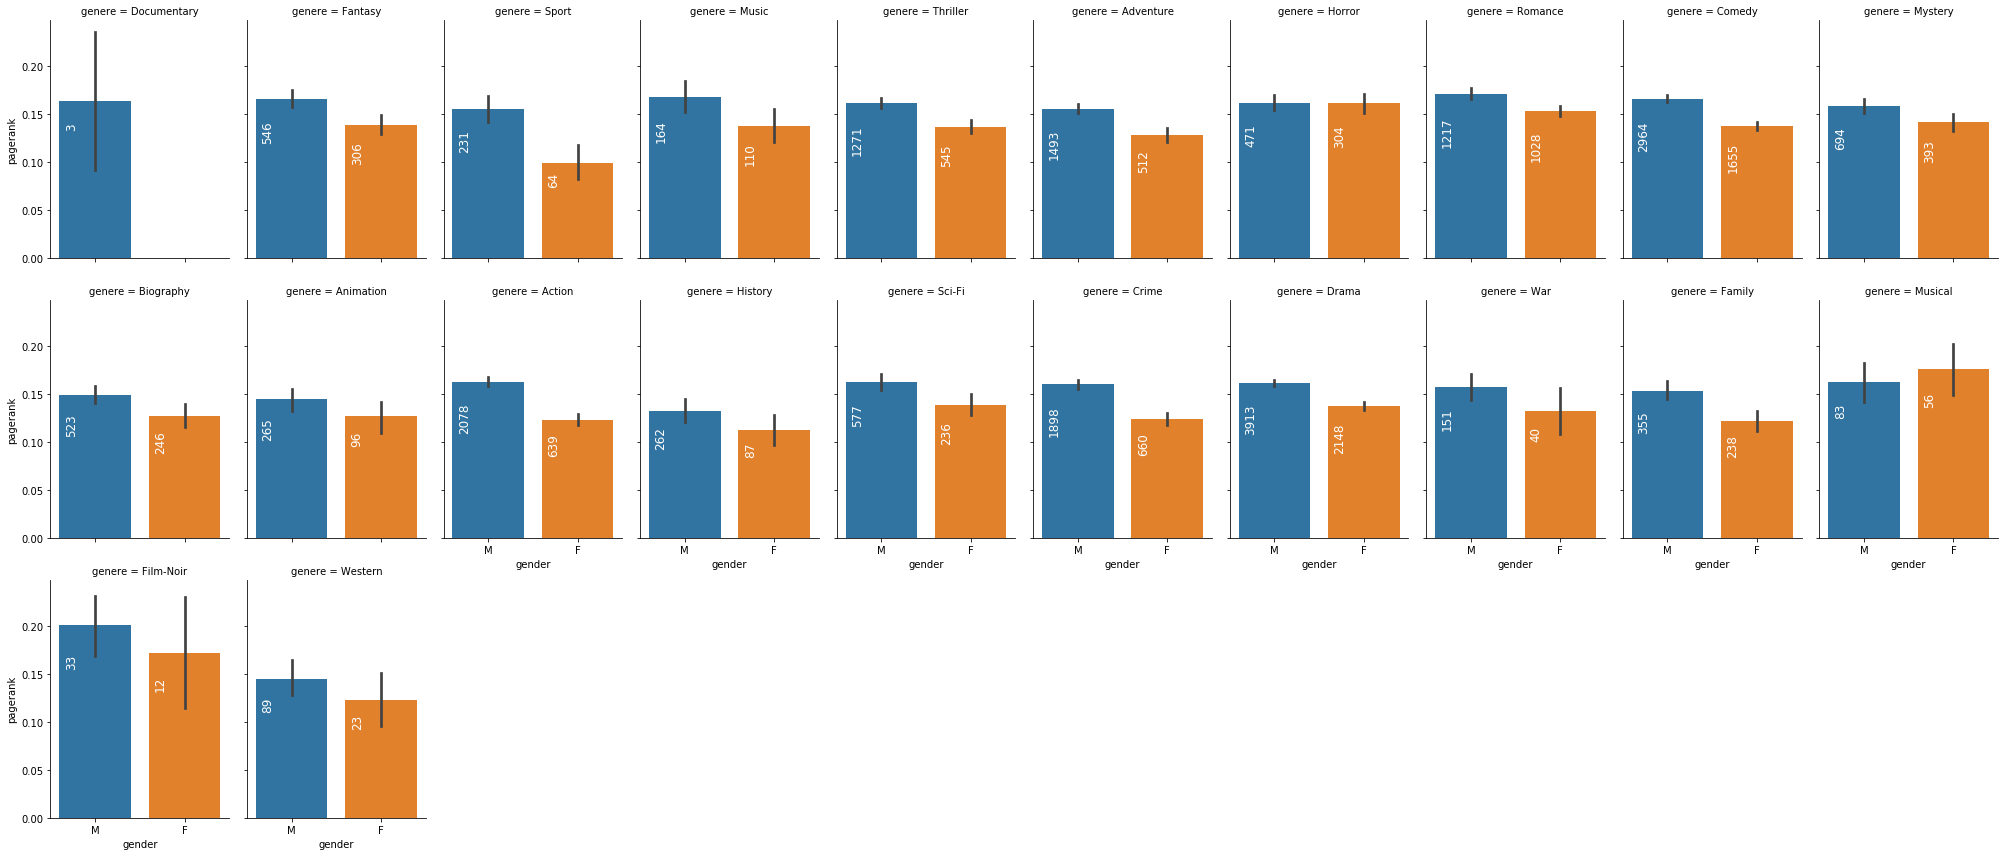

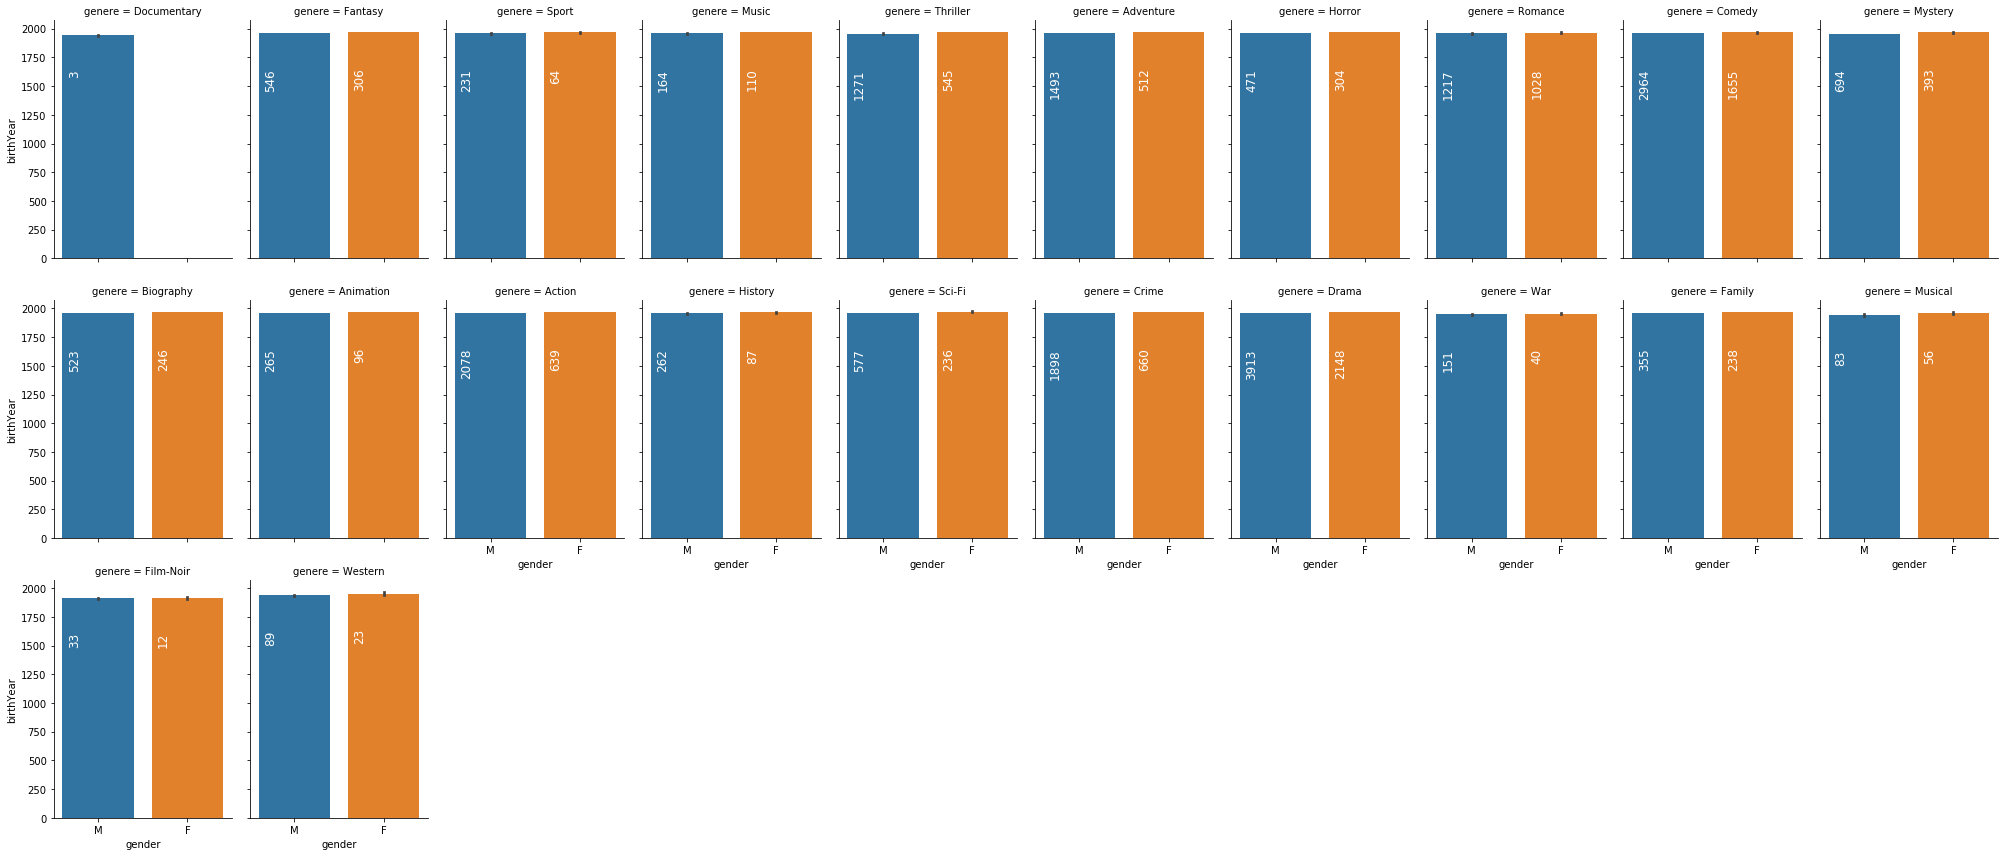

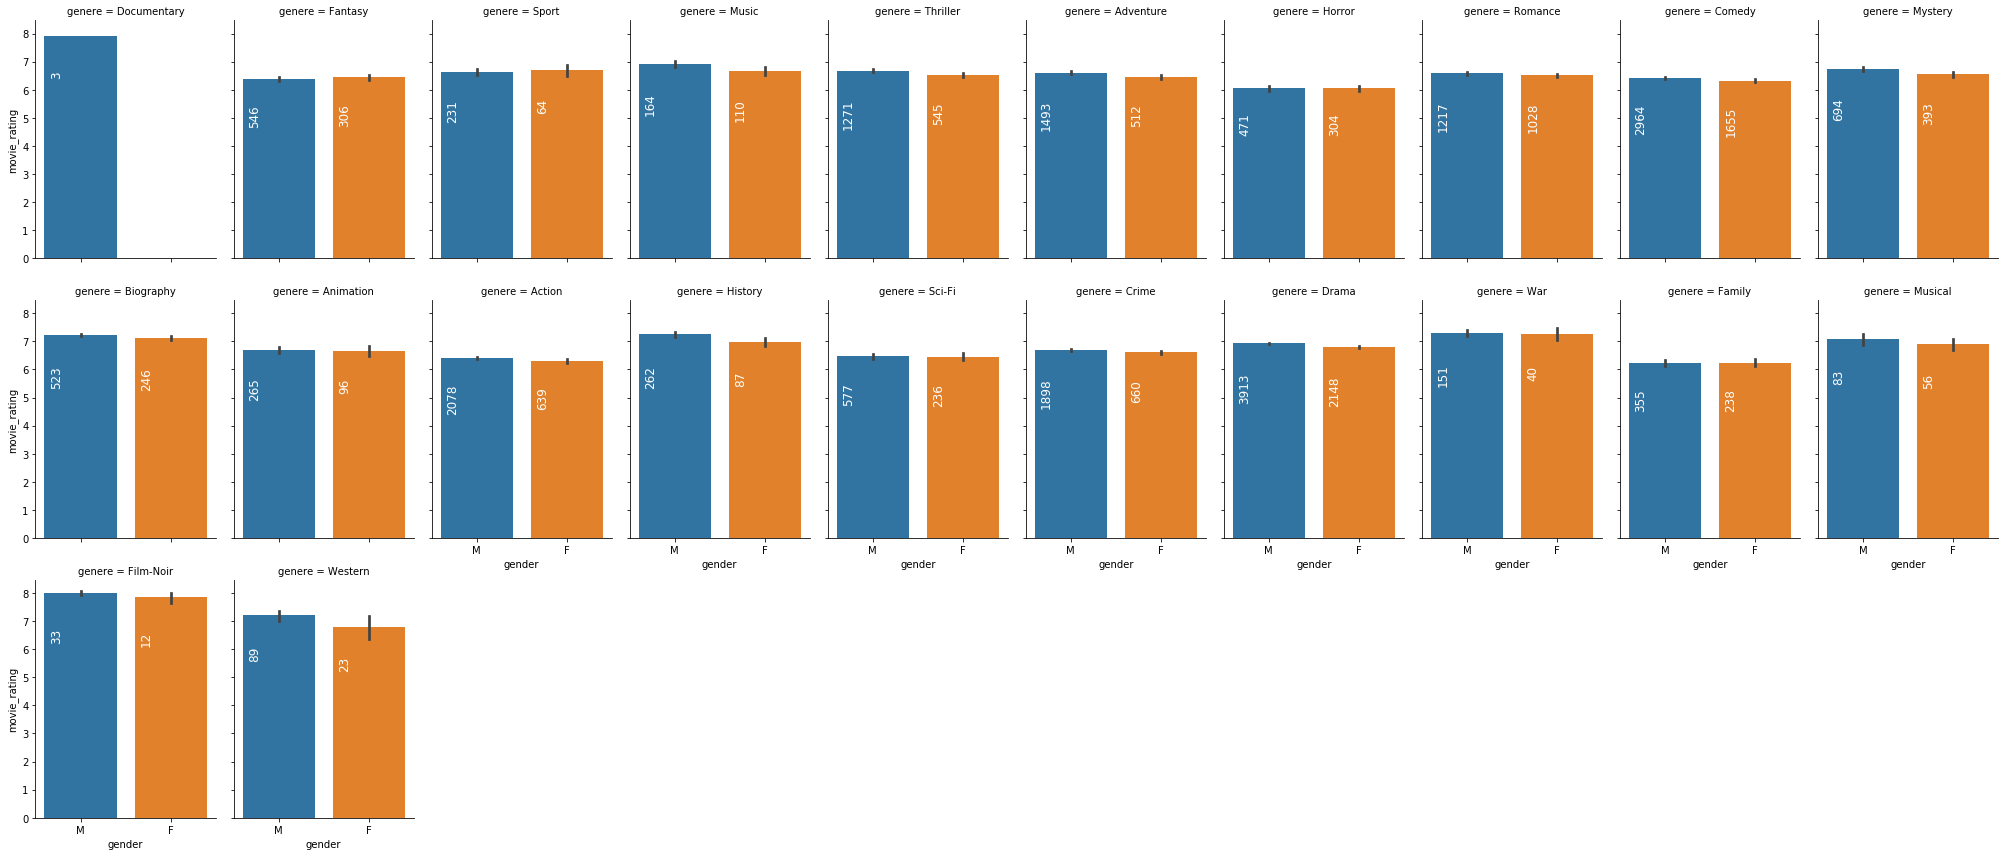

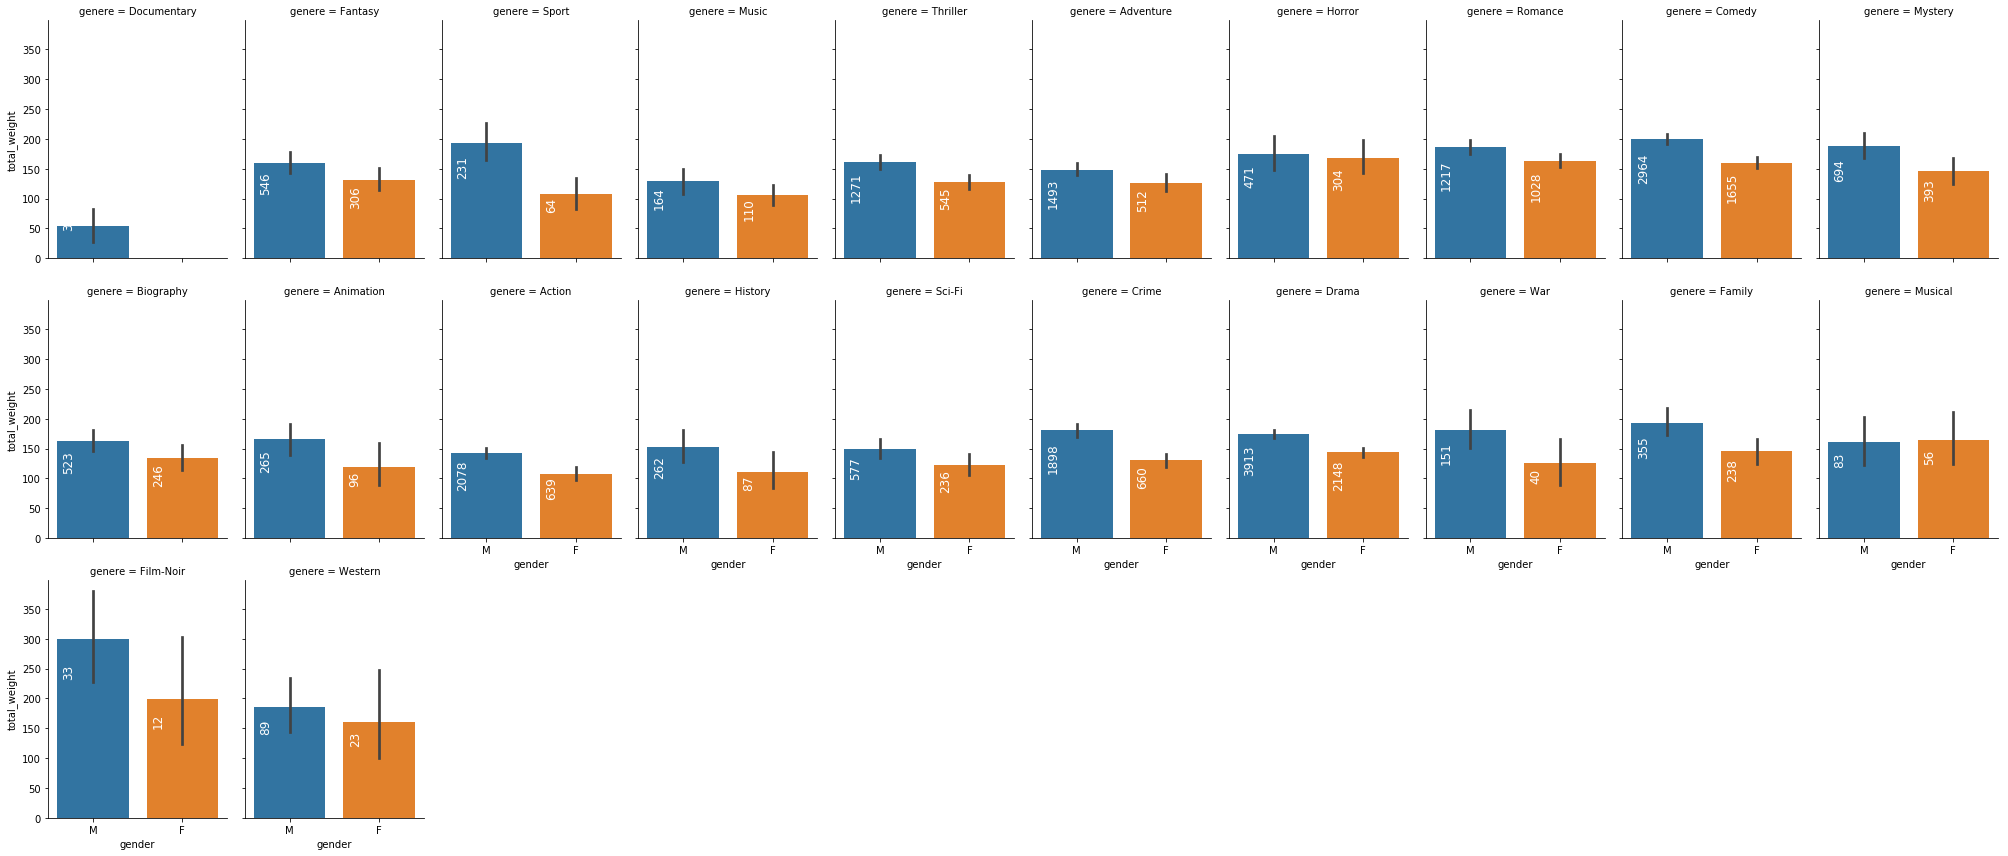

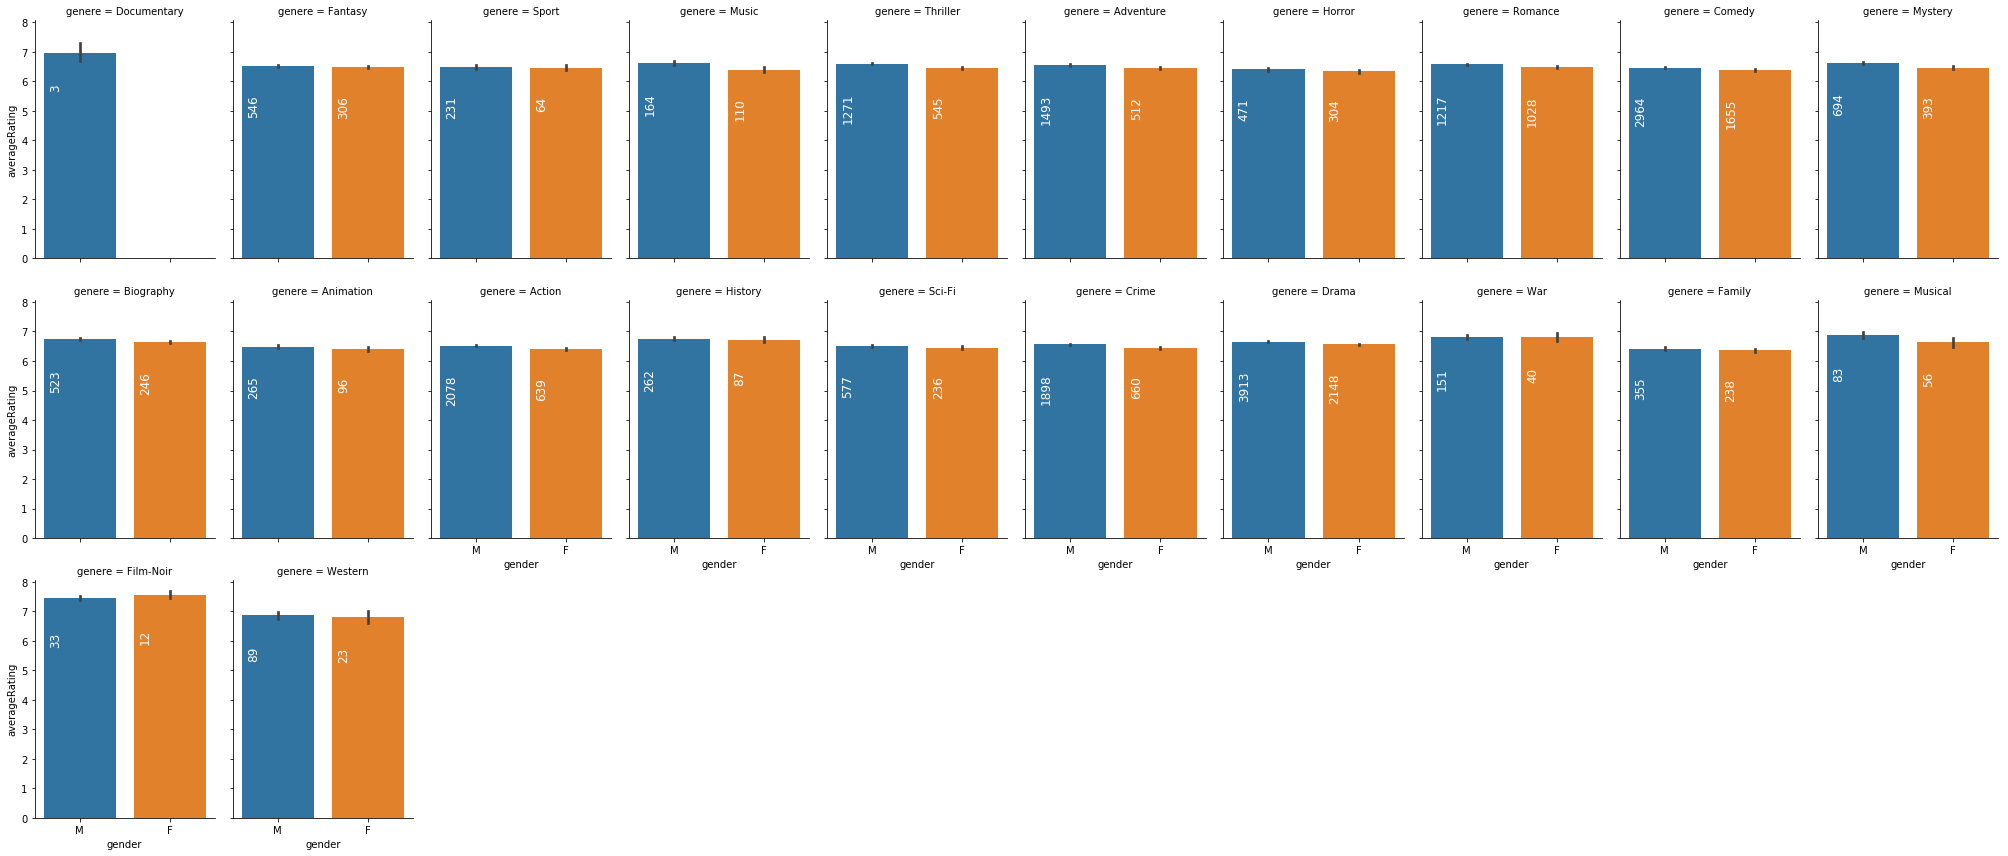

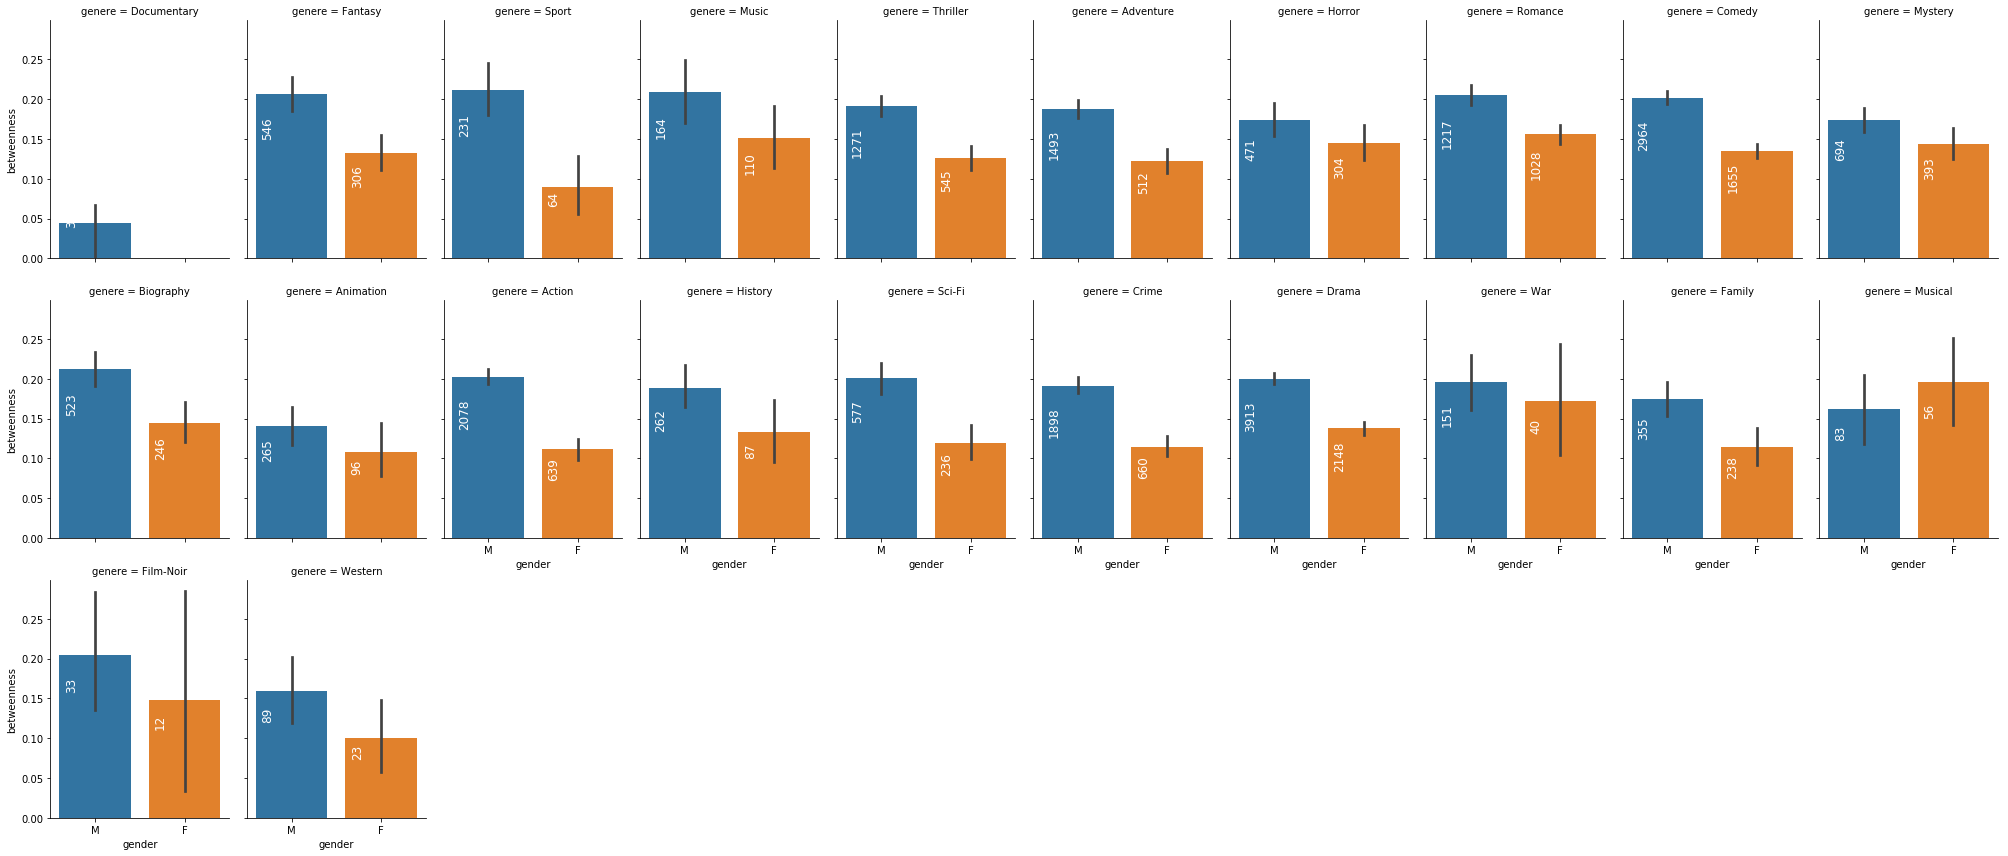

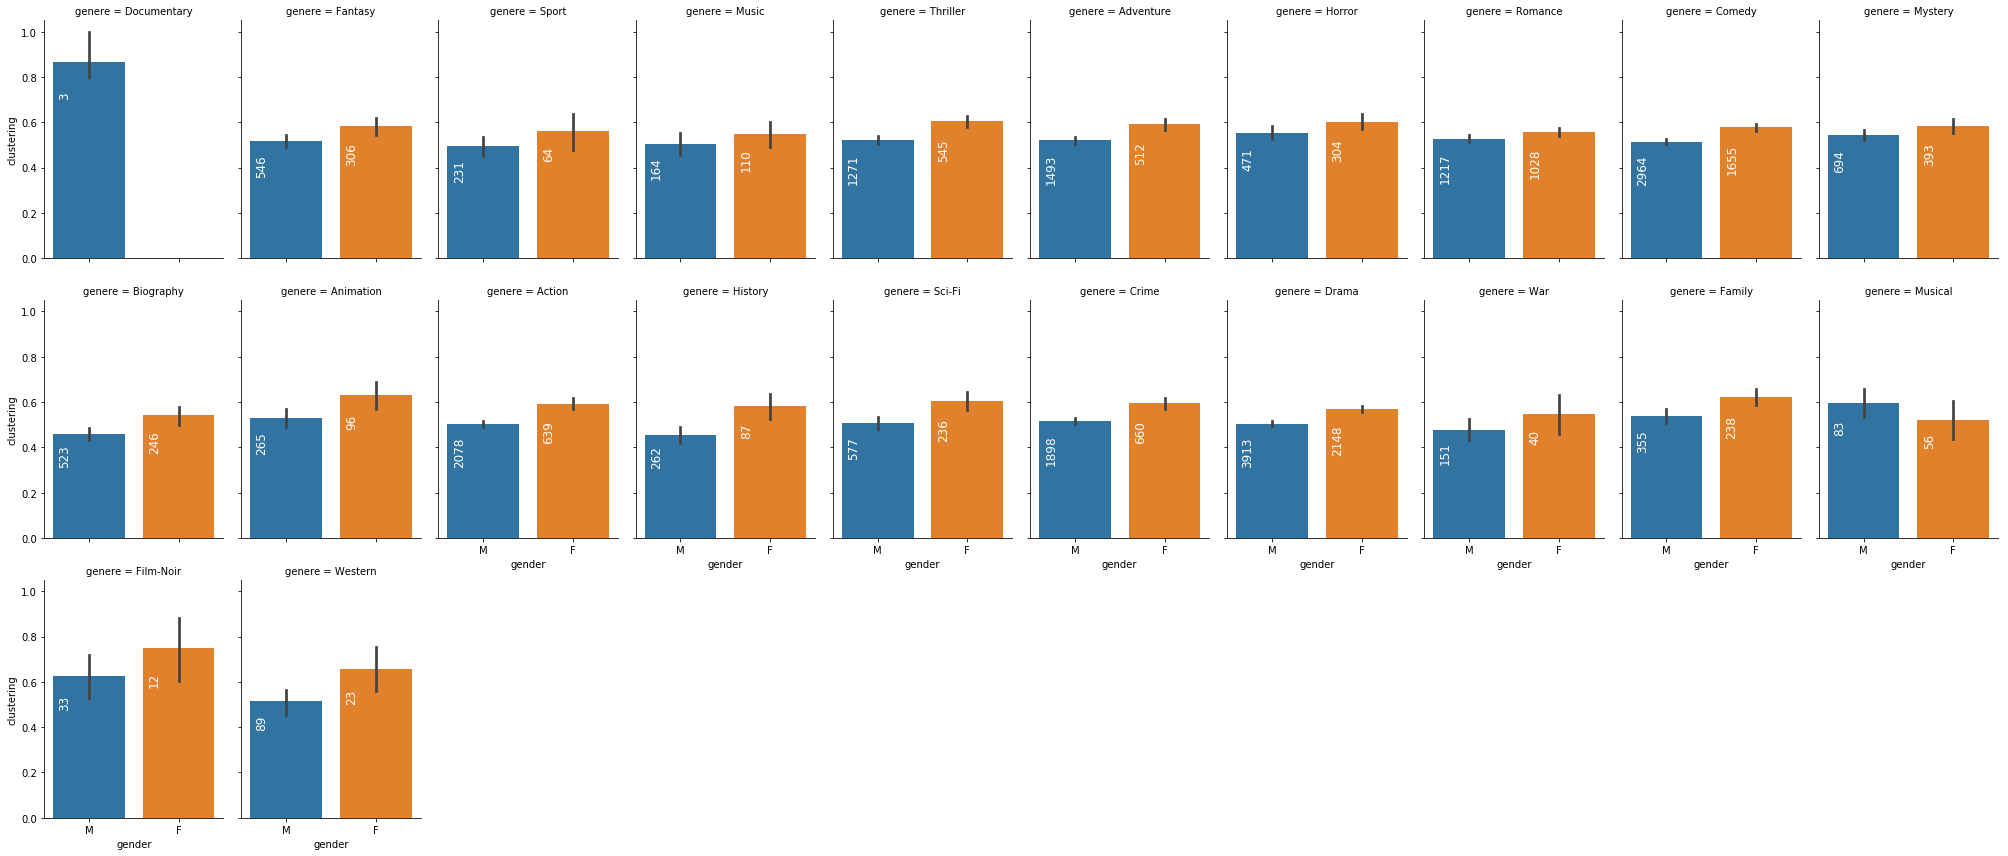

In [81]:
import seaborn as sns
bins = ["M", "F"]

for feature in id_vars:
    if feature != "gender":
        g = sns.catplot(x="gender", y=feature, col="genere",
                         data=df_chart, kind="bar", col_wrap=10,
                         height=4, aspect=.7);
        for i in np.arange(22):
        #     for j in np.arange(4):
                ax1 = g.facet_axis(0,i)
                plot_genere = ax1.title._text.split(" = ")[1]
                for i, p in enumerate(ax1.patches):
                    if str(p.get_height()) != 'nan':
                        ax1.text(p.get_x() + 0.06, p.get_height() * .8, ((df_chart["genere"]==plot_genere) & (df_chart["gender"]==bins[i])).sum(), color='white', rotation='vertical', size='large')

        g.savefig(f"features/{feature}.png")

#### Triangles

In [6]:
from turicreate import SFrame

In [7]:
triagles = SFrame.read_csv("../temp/triangles.csv", usecols=["0","1","2","3","4"])

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 100 lines in 0.363715 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 445195 lines in 0.340409 secs.

In [11]:
actors_gender = imdb_data.actors[["primaryName", "gender"]].unstack(["primaryName", "gender"])[0]

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.principals.tsv.gz

Parsing completed. Parsed 100 lines in 1.1109 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int,str,str,str,list]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 1190442 lines. Lines per second: 843164

Read 9496862 lines. Lines per second: 1.43942e+06

Read 16520285 lines. Lines per second: 1.37434e+06

Read 22411064 lines. Lines per second: 1.29359e+06

Read 28324408 lines. Lines per second: 1.2409e+06

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.principals.tsv.gz

Parsing completed. Parsed 30924394 lines in 24.9406 secs.

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 100 lines in 1.26849 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 686206 lines. Lines per second: 455520

Read 5697715 lines. Lines per second: 835426

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 8957228 lines in 10.0559 secs.

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.ratings.tsv.gz

Parsing completed. Parsed 100 lines in 0.350395 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.ratings.tsv.gz

Parsing completed. Parsed 883732 lines in 0.40366 secs.

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.basics.tsv.gz

Parsing completed. Parsed 100 lines in 1.02249 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,int,int,str,int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 648045 lines. Lines per second: 485999

Unable to parse line "tt2347742	tvEpisode	"No sufras por la alergia esta primavera	"No sufras por la alergia esta primavera	0	2004	\N	\N	\N"

Unable to parse line "tt7841930	tvEpisode	"Stop and Hear the Cicadas/Cold-Blooded	"Stop and Hear the Cicadas/Cold-Blooded	0	2018	\N	24	Animation,Family"

2 lines failed to parse correctly

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.basics.tsv.gz

Parsing completed. Parsed 5396835 lines in 6.38219 secs.

In [12]:
actors_gender = actors_gender["Dict of primaryName_gender"]

In [16]:
name_gender = imdb_data.first_name_gender.unstack(["First Name", "Gender Dict"])[0]["Dict of First Name_Gender Dict"]

In [23]:
def get_actor_gender(actor):
    try:
        return actors_gender[actor]
    except KeyError:
        try:
            first_name = actor.split(" ")[0].lower()
            return name_gender[first_name]["Gender"][:1]
        except KeyError:
            return None

In [24]:
triagles_gender = triagles.apply(lambda x: [get_actor_gender(x["0"]),get_actor_gender(x["1"]),get_actor_gender(x["2"])])

In [26]:
triagles_gender = triagles_gender.unpack()

In [27]:
triagles_gender["movie"] = triagles["3"]
triagles_gender["year"] = triagles["4"]

In [28]:
triagles_gender= triagles_gender.dropna()

In [29]:
triagles_gender = triagles_gender.join(imdb_data.title, {"movie":"primaryTitle","year":"startYear"})

In [30]:
triagles_gender_bin = SFrame()
triagles_gender_bin["1"]= triagles_gender["X.0"]=="M"
triagles_gender_bin["2"]= triagles_gender["X.1"]=="M"
triagles_gender_bin["3"]= triagles_gender["X.2"]=="M"

In [31]:
triagles_gender_bin["sum"] = triagles_gender_bin.apply(lambda x: x["1"]+x["2"]+x["3"])

In [32]:
triagles_gender_bin.to_dataframe()["sum"].value_counts()

2    164085
3    127693
1     87889
0     19643
Name: sum, dtype: int64

In [33]:
triagles_gender_bin["genres"] =triagles_gender["genres"].apply(lambda x: x.split(","))

In [34]:
triagles_gender_bin = triagles_gender_bin.unpack("genres")



In [35]:
triagles_gender_bin.save(f"../temp/gender_tri.csv", format="csv")

In [36]:
triagles_gender_bin = SFrame.read_csv(f"../temp/gender_tri.csv")

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/gender_tri.csv

Parsing completed. Parsed 100 lines in 0.180499 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/gender_tri.csv

Parsing completed. Parsed 399310 lines in 0.199953 secs.

In [37]:
triagles_gender_bin = triagles_gender_bin.pack_columns(column_name_prefix="genres")

In [38]:
triangles_df = triagles_gender_bin.to_dataframe()

In [39]:
for genre in set().union(*triangles_df.genres.values):
    triangles_df[genre] = triangles_df.apply(lambda _: int(genre in _.genres), axis=1)

In [40]:
triangles_df = triangles_df.drop(["1","2","3","genres"],axis=1)

In [41]:
triangles_df = triangles_df.rename(columns={"sum":"Males in triangle"})

In [58]:
piv = pd.pivot_table(triangles_df,columns="Males in triangle", values=genres, aggfunc=np.sum)

In [59]:
piv

Males in triangle,0,1,2,3
Action,877,5620,14509,13733
Adventure,666,5417,13752,12811
Animation,501,2782,5431,3888
Biography,640,3087,7845,9874
Comedy,7761,35318,63100,45593
Crime,1190,7385,18343,16046
Documentary,2026,7590,14458,11969
Drama,8249,36162,62950,47728
Family,959,4067,7652,6320
Fantasy,451,2618,5340,4395


In [60]:
piv["total"] = piv[0]+piv[1]+ piv[2]+ piv[3]

In [61]:
for i in range(4):
    piv[i] = piv[i]/piv["total"]

In [62]:
piv

Males in triangle,0,1,2,3,total
Action,0.025245,0.161778,0.417657,0.395319,34739
Adventure,0.020401,0.165932,0.421246,0.392422,32646
Animation,0.039756,0.220759,0.430963,0.308522,12602
Biography,0.029842,0.143943,0.365802,0.460412,21446
Comedy,0.051136,0.232704,0.415755,0.300405,151772
Crime,0.027698,0.171888,0.426939,0.373475,42964
Documentary,0.056211,0.210582,0.401132,0.332076,36043
Drama,0.053189,0.233169,0.405896,0.307746,155089
Family,0.050479,0.214075,0.402779,0.332667,18998
Fantasy,0.035223,0.204467,0.417057,0.343252,12804


In [63]:
from itertools import islice
gender_top_movies = islice(gender_in_top_movies(), 1000)

In [64]:
gender_top_movies = list(gender_top_movies)

 12%|█▏        | 1394/11343 [02:13<22:55,  7.23it/s] 

In [65]:
import itertools
gender_top_100 = list(itertools.chain.from_iterable(gender_top_movies[:100]))
gender_top_1000 = list(itertools.chain.from_iterable(gender_top_movies))

 12%|█▏        | 1394/11343 [02:30<22:55,  7.23it/s]

In [66]:
print(pd.DataFrame(gender_top_100)[0].value_counts())
print(pd.DataFrame(gender_top_1000)[0].value_counts())

M    747
F    237
U     27
Name: 0, dtype: int64
M    6110
F    2366
U     303
Name: 0, dtype: int64


In [67]:
gender_centrality = pd.read_csv("../temp/gender.csv", index_col=0)

In [68]:
rank_pagerank = pd.Series()
rank_degree_centrality = pd.Series()
for g in gender_centrality.groupby("movie_name"):
    rank_pagerank = rank_pagerank.append(g[1]["pagerank"].argsort())
    rank_degree_centrality = rank_degree_centrality.append(g[1]["degree_centrality"].argsort())


In [69]:
gender_centrality["rank_pagerank"] = rank_pagerank
gender_centrality["rank_degree_centrality"] = rank_degree_centrality

In [70]:
gender_centrality = gender_centrality.fillna("U")

In [71]:
rank_degree = pd.pivot_table(gender_centrality[["gender","rank_degree_centrality"]],index="gender", columns="rank_degree_centrality", aggfunc=len).T

In [72]:
rank_degree["F%"]  = rank_degree["F"] / (rank_degree["F"] + rank_degree["M"])
rank_degree["M%"]  = rank_degree["M"] / (rank_degree["F"] + rank_degree["M"])

In [73]:
rank_degree

gender,F,M,U,F%,M%
rank_degree_centrality,,,,,
0,1968.0,4065.0,440.0,0.326206,0.673794
1,1988.0,4023.0,462.0,0.330727,0.669273
2,1938.0,4092.0,443.0,0.321393,0.678607
3,2013.0,4039.0,421.0,0.332617,0.667383
4,1993.0,4033.0,447.0,0.330733,0.669267
5,1930.0,4149.0,394.0,0.317486,0.682514
6,2001.0,4049.0,423.0,0.330744,0.669256
7,1987.0,4080.0,406.0,0.327509,0.672491
8,2046.0,4022.0,405.0,0.337179,0.662821


In [74]:
rank_pagerank = pd.pivot_table(gender_centrality[["gender","rank_pagerank"]],index="gender", columns="rank_pagerank", aggfunc=len).T

In [75]:
rank_pagerank["F%"]  = rank_pagerank["F"] / (rank_pagerank["F"] + rank_pagerank["M"])
rank_pagerank["M%"]  = rank_pagerank["M"] / (rank_pagerank["F"] + rank_pagerank["M"])

In [76]:
rank_pagerank

gender,F,M,U,F%,M%
rank_pagerank,,,,,
0,1947.0,4072.0,454.0,0.323476,0.676524
1,1968.0,4022.0,483.0,0.328548,0.671452
2,2002.0,4020.0,451.0,0.332448,0.667552
3,2108.0,3917.0,448.0,0.349876,0.650124
4,2004.0,4000.0,469.0,0.333777,0.666223
5,2014.0,4011.0,448.0,0.334274,0.665726
6,1962.0,4110.0,401.0,0.323123,0.676877
7,1993.0,4091.0,389.0,0.327581,0.672419
8,1991.0,4103.0,379.0,0.326715,0.673285


In [444]:
for gender in set().union(gender_centrality.gender.values):
    gender_centrality[gender] = gender_centrality.apply(lambda _: int(gender in _.gender), axis=1)

In [380]:
gender_centrality[gender_centrality["rank_pagerank"] < 10].groupby("movie_name").sum().sort_values("M", ascending=False)

,betweenness,closeness,clustering,degree,degree_centrality,imdb_rating,pagerank,total_weight,year,rank_pagerank,rank_degree_centrality,F,U,M
movie_name,,,,,,,,,,,,,,
Batman Begins (2005) - roles,0.586720,5.879731,5.427273,50,3.333333,83.0,0.620242,442,20050,45,56,0,0,10
When the Sky Falls - roles,0.649981,5.657325,5.448918,62,3.100000,66.0,0.515255,379,20000,45,71,0,0,10
Land of the Lost - roles,0.000000,5.369069,9.000000,26,1.368421,54.0,0.182857,202,20090,45,59,0,0,10
The Onion Movie - roles,0.670330,3.024231,1.369048,21,1.500000,63.0,0.762108,187,20080,45,53,0,0,10
Star Wars: Episode V - The Empire Strikes Back - roles,0.624542,5.913903,7.347985,40,2.857143,88.0,0.679043,303,19800,45,65,0,0,10
Star Wars: Episode VI - Return of the Jedi - roles,0.600000,5.390247,4.853175,44,3.142857,83.0,0.534525,239,19830,45,60,0,0,10
The Name of the Rose - roles,0.121212,5.741679,6.969048,35,2.916667,78.0,0.576599,409,19860,45,64,0,0,10
Kong: Skull Island - roles,0.427183,5.112554,5.539827,40,2.500000,67.0,0.484871,161,20170,45,80,0,0,10
Demolition Man - roles,0.420370,7.121554,7.579365,55,5.500000,66.0,0.855541,695,19930,45,47,0,0,10


In [393]:
gender_raing_grouped = gender_centrality[gender_centrality["rank_pagerank"] < 10].groupby("movie_name").sum()

In [394]:
gender_raing_grouped["imdb_rating"] = gender_raing_grouped["imdb_rating"] /10

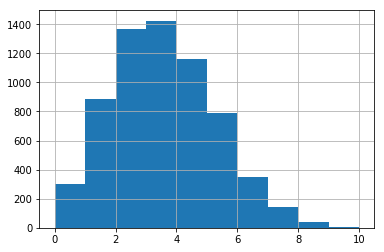

In [310]:
gender_centrality[gender_centrality["rank_pagerank"] < 10].groupby("movie_name").sum()["F"].hist(bins=10)

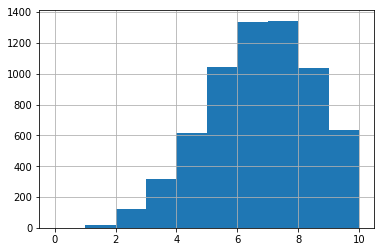

In [311]:
gender_centrality[gender_centrality["rank_pagerank"] < 10].groupby("movie_name").sum()["M"].hist(bins=10)

In [316]:
m = gender_centrality[gender_centrality["rank_pagerank"] < 10].groupby("movie_name").sum()["M"].value_counts()

In [408]:
f = gender_centrality[gender_centrality["rank_pagerank"] < 10].groupby("movie_name").sum()["F"].value_counts()

In [470]:
f_overtime = gender_centrality[gender_centrality["rank_pagerank"] < 10].groupby("movie_name").sum()

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


KeyError: 'mean'

In [447]:
f_overtime["year"] = f_overtime["year"] / 10

In [482]:
f_overtime[["year", "F"]].groupby("year").agg(["count","mean"]) .tail(60)

F          
       count      mean
year                  
1959.0    17  2.588235
1960.0    22  3.045455
1961.0    18  2.333333
1962.0    12  2.833333
1963.0    18  2.500000
1964.0    15  3.733333
1965.0    23  2.565217
1966.0    23  2.521739
1967.0    23  2.217391
1968.0    22  2.363636
1969.0    18  2.388889
1970.0    25  2.880000
1971.0    21  2.809524
1972.0    23  2.478261
1973.0    25  2.840000
1974.0    23  2.565217
1975.0    31  3.032258
1976.0    33  2.666667
1977.0    18  3.500000
1978.0    35  2.600000
1979.0    27  2.518519
1980.0    41  2.512195
1981.0    31  2.677419
1982.0    39  3.205128
1983.0    54  2.759259
1984.0    54  3.018519
1985.0    43  2.860465
1986.0    61  2.639344
1987.0    62  3.016129
1988.0    75  3.120000
1989.0    72  2.763889
1990.0    72  2.527778
1991.0    95  2.894737
1992.0    73  2.986301
1993.0    99  2.868687
1994.0    95  3.010526
1995.0   109  2.908257
1996.0   121  3.033058
1997.0   105  2.980952
1998.0   120  3.066667
1999.0   150  3.180000
2000.0   146  3.068493
2001.0   144  3.152778
2002.0   149  3.006711
2003.0   148  3.135135
2004.0   168  3.005952
2005.0   206  3.368932
2006.0   199  3.246231
2007.0   228  3.298246
2008.0   238  3.273109
2009.0   254  3.401575
2010.0   242  3.347107
2011.0   252  3.178571
2012.0   244  3.258197
2013.0   283  3.169611
2014.0   279  3.118280
2015.0   245  3.175510
2016.0   248  3.221774
2017.0   242  3.223140
2018.0   154  3.266234

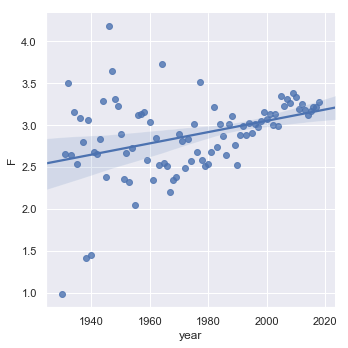

In [483]:
sea = f_overtime[["year", "F"]].groupby("year").mean()
sea["year"] = sea.index.values
# sea = sea[sea["year"] > 1950]
import seaborn as sns
sns.set(style="darkgrid")


# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="year", y="F", data=sea[["year","F"]],
               palette=pal, y_jitter=.02)
# g.set(xlim=(0, 80), ylim=(-.05, 1.05))

In [464]:
!python -m pip install statsmodels

In [459]:
sea

,F,year
year,,
1930.0,1.000000,1930.0
1931.0,2.666667,1931.0
1932.0,3.500000,1932.0
1933.0,2.666667,1933.0
1934.0,3.166667,1934.0
1935.0,2.555556,1935.0
1936.0,3.100000,1936.0
1937.0,2.800000,1937.0
1938.0,1.400000,1938.0


In [318]:
gender_histogram = pd.DataFrame()
gender_histogram["m"] = m
gender_histogram["f"] = f

In [333]:
gender_histogram["i"] = gender_histogram.index.values

In [334]:
gender_histogram

,m,f,i
7,1344,140,7
6,1338,352,6
5,1044,788,5
8,1035,42,8
4,618,1162,4
9,510,6,9
3,317,1424,3
10,125,1,10
2,123,1369,2
1,18,887,1


In [360]:
hist2 = gender_centrality[gender_centrality["rank_pagerank"] < 10].groupby("movie_name").sum()

In [361]:
hist2

,betweenness,closeness,clustering,degree,degree_centrality,pagerank,total_weight,year,rank_pagerank,rank_degree_centrality,F,U,M
movie_name,,,,,,,,,,,,,
'G' Men - roles,0.213463,8.671749,8.534560,91,8.272727,0.876405,1055,19350,45,46,2,2,6
10 Things I Hate About You - roles,1.086996,4.992706,3.234921,33,2.538462,0.681126,171,19990,45,63,4,1,5
10 Years - roles,0.293609,6.372533,6.580643,77,4.052632,0.469819,1434,20110,45,73,4,0,6
10 to Midnight - roles,0.642540,5.910849,8.248629,55,3.666667,0.585498,265,19830,45,72,5,1,4
"10,000 Saints - roles",0.472222,7.528571,7.580952,58,6.444444,1.000000,1298,20150,45,45,3,1,6
100 Streets - roles,0.040278,4.082388,4.766667,23,1.437500,0.423619,106,20160,45,65,4,0,6
101 Dalmatians (1961) - roles,0.554714,5.634436,4.473810,44,3.666667,0.607038,741,19610,45,52,5,1,4
101 Dalmatians - roles,0.673382,5.529398,4.686508,54,3.857143,0.575242,713,19610,45,76,4,0,6
102 Dalmatians - roles,0.633333,6.842555,7.288889,49,4.900000,0.960209,793,20000,45,45,2,0,8


In [359]:
import seaborn as sns
sns.set(style="whitegrid")

# Load the example Titanic dataset
titanic = sns.load_dataset("titanic")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="variable", y="value", data=hist2,
                height=6, kind="count", palette="muted")


ValueError: Either `x` or `y` must be None for count plots

In [370]:
gender_histogram["m"]

7     1344
6     1338
5     1044
8     1035
4      618
9      510
3      317
10     125
2      123
1       18
0        1
Name: m, dtype: int64

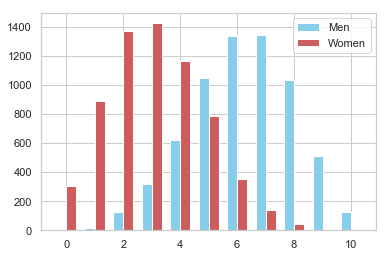

In [373]:
import numpy as np
import matplotlib.pyplot as plt

men_means, men_std = (20, 35, 30, 35, 27), (2, 3, 4, 1, 2)
women_means, women_std = (25, 32, 34, 20, 25), (3, 5, 2, 3, 3)

ind = np.arange(len(gender_histogram["i"]))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(gender_histogram["i"] - width/2, gender_histogram["m"], width,
                color='SkyBlue', label='Men')
rects2 = ax.bar(gender_histogram["i"] + width/2, gender_histogram["f"], width,
                color='IndianRed', label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(ind)
# ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
ax.legend()


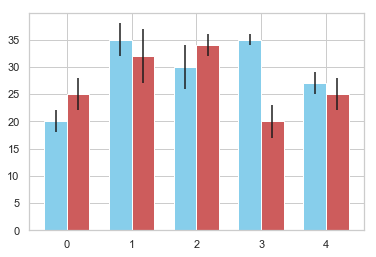

In [365]:
import numpy as np
import matplotlib.pyplot as plt

men_means, men_std = (20, 35, 30, 35, 27), (2, 3, 4, 1, 2)
women_means, women_std = (25, 32, 34, 20, 25), (3, 5, 2, 3, 3)

ind = np.arange(len(men_means))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, men_means, width, yerr=men_std,
                color='SkyBlue', label='Men')
rects2 = ax.bar(ind + width/2, women_means, width, yerr=women_std,
                color='IndianRed', label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(ind)
# ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
# ax.legend()

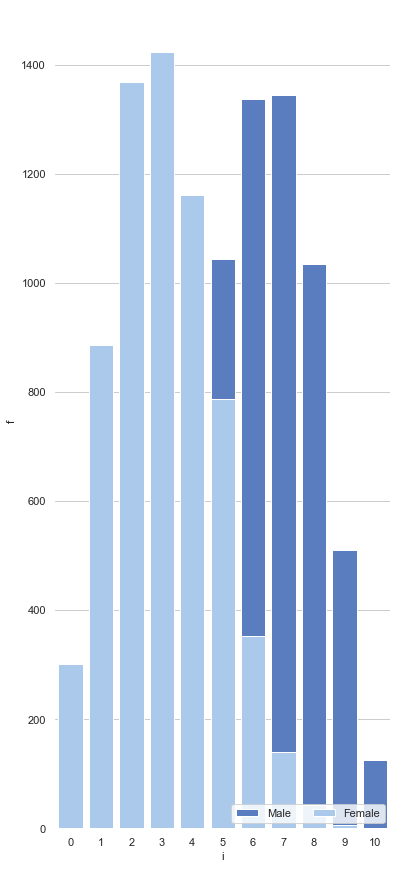

In [346]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
sns.set_color_codes("muted")
sns.barplot(x="i", y="m", data=gender_histogram,
            label="Male", color="b")
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="i", y="f", data=gender_histogram,
            label="Female", color="b")

# Plot the crashes where alcohol was involved


ax.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)

In [349]:
hist =pd.melt(gender_histogram, id_vars=['i'], value_vars=['f', 'm']) 
hist

,i,variable,value
0,7,f,140
1,6,f,352
2,5,f,788
3,8,f,42
4,4,f,1162
5,9,f,6
6,3,f,1424
7,10,f,1
8,2,f,1369
9,1,f,887


In [485]:
import requests

r = requests.get("http://bechdeltest.com/api/v1/getAllMovies")

In [489]:
bechdel = r.json()

In [496]:
bechdel_df = pd.DataFrame(bechdel)

In [792]:
bechdel= SFrame.read_csv("../data/bechdel.csv", column_type_hints={"imdbid": str})

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 100 lines in 0.032224 secs.

These column type hints were not used: X1

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 7871 lines in 0.011486 secs.

In [795]:
bechdel.sort("year", False)

X1,id,imdbid,rating,title,year
7870,8423,0365545,3,Nappily Ever Aftet,2018
7869,8414,3829266,1,"Predator, The",2018
7868,8397,7282468,0,Burning,2018
7867,8385,3846674,3,To All the Boys I&#39;veLoved Before ...,2018
7866,8381,2231461,3,Rampage,2018
7865,8369,4779682,3,"Meg, The",2018
7864,8365,6791096,3,I Feel Pretty,2018
7863,8349,7279188,3,Woman at War,2018
7862,8345,7424200,3,Teen Titans Go! To theMovies ...,2018
7861,8337,6911608,3,Mamma Mia! Here We GoAgain ...,2018


In [807]:
bechdel["tconst"] = "tt" + bechdel["imdbid"]

In [509]:
bechdel_triangles["1"]= bechdel_triangles["X.0"]=="M"
bechdel_triangles["2"]= bechdel_triangles["X.1"]=="M"
bechdel_triangles["3"]= bechdel_triangles["X.2"]=="M"

7871

In [808]:
bechdel_imdb_rating= imdb_data.rating.join(bechdel)

In [810]:
bechdel_imdb_rating

tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear
tt0000003,6.6,1030,short,Pauvre Pierrot,Pauvre Pierrot,0,1892
tt0000012,7.4,8563,short,The Arrival of a Train,L'arrivée d'un train à LaCiotat ...,0,1896
tt0000014,7.2,3726,short,Tables Turned on theGardener ...,L'arroseur arrosé,0,1895
tt0000091,6.7,2192,short,The House of the Devil,Le manoir du diable,0,1896
tt0000131,5.8,829,short,A Terrible Night,Une nuit terrible,0,1896
tt0000211,7.5,2670,short,A Trip to the Moon,La lune à un mètre,0,1898
tt0000230,6.5,1101,short,Cinderella,Cendrillon,0,1899
tt0000246,6.5,790,short,A Turn of the CenturyIllusionist ...,L'impressionniste fin desiècle ...,0,1899
tt0000272,5.6,547,short,As Seen Through aTelescope ...,As Seen Through aTelescope ...,0,1900
tt0000300,7.0,879,short,The Enchanted Drawing,The Enchanted Drawing,0,1900


In [87]:
bechdel_imdb = imdb_data.title.join(bechdel)

In [811]:
bechdel_imdb_rating.save("../data/bechdel_imdb.csv", format="csv")

In [90]:
triagles_gender

X.0,X.1,X.2,movie,year,tconst,titleType,originalTitle,isAdult,endYear,runtimeMinutes
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,F,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,F,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,F,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145


In [89]:
triagles_gender["1"]= triagles_gender["X.0"]=="M"
triagles_gender["2"]= triagles_gender["X.1"]=="M"
triagles_gender["3"]= triagles_gender["X.2"]=="M"
triagles_gender["total"] = triagles_gender["1"] + triagles_gender["2"] + triagles_gender["3"]

In [93]:
from turicreate import aggregate as agg
moive_triangle = triagles_gender.groupby(["tconst","total"], operations={'count': agg.COUNT()})
# type(moive_triangle)
traingles_at_movie = moive_triangle.to_dataframe().pivot_table(index=['tconst'], values ="count", columns='total', aggfunc= lambda x: x)
traingles_at_movie = traingles_at_movie.fillna(0)

In [107]:
traingles_at_movie["tconst"] = traingles_at_movie.index.values

In [344]:
bechdel_triangles = SFrame(traingles_at_movie).join(bechdel_imdb, {"tconst":"tconst"})

In [345]:
bechdel_triangles_df = bechdel_triangles.to_dataframe()
bechdel_triangles_df["rating"] = bechdel_triangles_df["rating"].astype(int)

In [571]:
graph_features = SFrame.read_csv("../temp/graph_features.csv")

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 100 lines in 0.05087 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[float,float,float,float,float,float,float,float,int,float,float,float,float,float,float,float,int,float,float,float,float,float,float,float,int,float,int,str,int,float,float,float,float,float,float,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 11331 lines in 0.055712 secs.

In [683]:
graph_features = graph_features[graph_features["node_number"] > 5]

In [684]:
bechdel_ml = graph_features.join(bechdel_triangles, on={"movie_name":"primaryTitle", "year":"year"})

In [685]:
len(bechdel_ml)

1619

In [686]:
bechdel_ml["rating"] = bechdel_ml["rating"] ==3

In [687]:
bechdel_ml = bechdel_ml.to_dataframe()

In [688]:
bechdel_ml= bechdel_ml.sort_values("year")

In [689]:
bechdel_ml = bechdel_ml.drop(["X1", "genres", 'title',"imdbid" ,"originalTitle",'startYear', "movie_name",'endYear', 'isAdult', 'tconst', 'titleType',
       'id'], axis=1)

In [690]:
bechdel_ml = bechdel_ml.fillna(0)

In [691]:
bechdel_ml["total_tir"] = bechdel_ml["0"]+bechdel_ml["1"]+ bechdel_ml["2"]+ bechdel_ml["3"]
for i in range(4):
    bechdel_ml[f"{i}%"] = bechdel_ml[str(i)]/bechdel_ml["total_tir"]

In [692]:
y = bechdel_ml.pop("rating")


In [703]:
n_valid = 600
X_valid, X_train  = split_vals(bechdel_ml, n_valid)
y_valid, y_train = split_vals(y, n_valid)

In [704]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100,max_depth=5, min_samples_split=10, min_samples_leaf=3,random_state=1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.4408039759807434, 0.5338539126015656, 0.8056918547595682, 0.715]


In [705]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid)[:, 1])

0.7801621121933622

In [740]:
def ranking_precision_score(y_true, y_score, k=10):
    """Precision at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    Returns
    -------
    precision @k : float
    """
    unique_y = np.unique(y_true)

    if len(unique_y) > 2:
        raise ValueError("Only supported for two relevance levels.")

    pos_label = unique_y[1]
    n_pos = np.sum(y_true == pos_label)
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    print(y_true)
    n_relevant = np.sum(y_true == pos_label)

    # Divide by min(n_pos, k) such that the best achievable score is always 1.0.
    return float(n_relevant) / min(n_pos, k)


In [777]:
import csv, os
from operator import itemgetter
from random import shuffle
from copy import deepcopy


class PrecisionKExtractor:
    def __init__(self, actual, predicted, probability):
        self._data = SFrame({"actual": actual, "predicted": predicted, "probability": probability})
        self._data = self._data.sort(["probability", "predicted"], ascending=False)


    def calculate_precision_k(self):
        k = float(1)
        current_sum = float(0)
        precision_k_list = []
        for n,row in enumerate(self._data):
            if row["predicted"] in [1, 0]:
                if row["actual"] == row["predicted"]:
                    current_sum += 1
            precision_k_list.append([n+1, current_sum / (n+1)])
        return precision_k_list

probas  = m.predict_proba(X_valid)[:, 1]
prediction = np.where(probas > 0.5, 1, 0)
pke = PrecisionKExtractor(y_valid.values, prediction ,m.predict_proba(X_valid)[:, 1])
# pke.extract_batch(True)


In [791]:
np.sum(y_valid.values == 1)

336

In [784]:
patk= pke.calculate_precision_k()

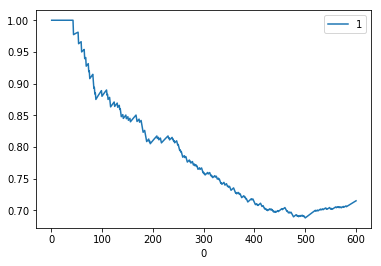

In [790]:
pd.DataFrame(patk).plot(0, 1)

In [783]:
pke._data[43]

{'actual': 0, 'predicted': 1, 'probability': 0.9068010345463788}

In [741]:
ranking_precision_score(y_valid.values, m.predict_proba(X_valid)[:, 1],10)

[1 1 1 1 1 1 1 1 1 1]


1.0

In [738]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index=X_train.columns.values,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
3%,0.163398
1%,0.148464
0%,0.105830
1,0.077285
0,0.064378
d_count,0.039918
3,0.029559
2%,0.023756
appearance-75%,0.020019
appearance-mean,0.016328


Confusion matrix, without normalization
[[175  89]
 [ 82 254]]
Normalized confusion matrix
[[0.66 0.34]
 [0.24 0.76]]


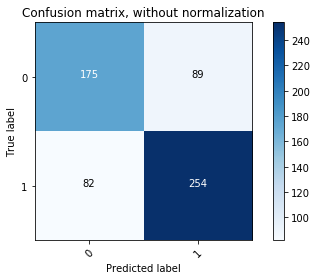

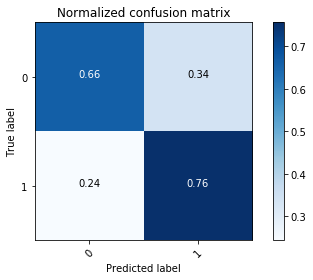

In [708]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


class_names = [0, 1]

y_pred = m.predict(X_valid)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred ,labels=class_names)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### T-test

In [156]:
from scipy.stats import ttest_ind

By Gender:

In [848]:
for col in df.columns.values:
    if "gender" not in col:
        print(f"{col}: {ttest_ind(male[col], female[col])}")

averageRating: Ttest_indResult(statistic=9.995310080935798, pvalue=2.0061205691329136e-23)
betweenness: Ttest_indResult(statistic=14.47808700729081, pvalue=4.463093573046e-47)
birthYear: Ttest_indResult(statistic=-13.854118276454045, pvalue=2.747727359268003e-43)
closeness: Ttest_indResult(statistic=6.994017205086648, pvalue=2.824591675984747e-12)
clustering: Ttest_indResult(statistic=-11.233471963278559, pvalue=4.006961762217375e-29)
deathYear: Ttest_indResult(statistic=12.863523119707292, pvalue=1.3382186181327065e-37)
degree: Ttest_indResult(statistic=5.888496172065184, pvalue=4.009987024528609e-09)
degree_centrality: Ttest_indResult(statistic=7.725657689270972, pvalue=1.2084317940553537e-14)
movie_rating: Ttest_indResult(statistic=5.605366615424667, pvalue=2.1276632340420762e-08)


/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

By genere:

In [161]:
for g in genres:
    print(g)
    for col in df.columns.values:
        if "gender" not in col:
            print(f"{col}: {ttest_ind(male[male[g] ==1][col], female[female[g] ==1][col])}")

Sci-Fi
averageRating: Ttest_indResult(statistic=2.878437280819165, pvalue=0.004088059565943305)
betweenness: Ttest_indResult(statistic=4.4996291792099425, pvalue=7.66896196147579e-06)
birthYear: Ttest_indResult(statistic=-9.858661504073039, pvalue=7.105041568554806e-22)
closeness: Ttest_indResult(statistic=2.5722957338637724, pvalue=0.010256834542517374)
clustering: Ttest_indResult(statistic=-3.3810096311148428, pvalue=0.0007522722396612554)
count: Ttest_indResult(statistic=4.097776656462591, pvalue=4.5353813867359104e-05)
deathYear: Ttest_indResult(statistic=4.2011514042390345, pvalue=2.9112593252964855e-05)
degree: Ttest_indResult(statistic=2.2234912824604782, pvalue=0.02642228782557747)
degree_centrality: Ttest_indResult(statistic=2.788844106965154, pvalue=0.005397644496793122)
runtimeMinutes: Ttest_indResult(statistic=1.173110027482423, pvalue=0.24105205531944865)
startYear: Ttest_indResult(statistic=-2.4747374438295173, pvalue=0.013510777011626104)
total_weight: Ttest_indResult(st

art_department: Ttest_indResult(statistic=-1.5549705342184899, pvalue=0.1202154552921671)
animation_department: Ttest_indResult(statistic=0.7527236174332852, pvalue=0.4517629134921668)
stunts: Ttest_indResult(statistic=1.0652038640343788, pvalue=0.28699689779190196)
sound_department: Ttest_indResult(statistic=nan, pvalue=nan)
casting_department: Ttest_indResult(statistic=-1.3286914217919525, pvalue=0.18420114037502272)
editorial_department: Ttest_indResult(statistic=0.7527236174332852, pvalue=0.4517629134921668)
cinematographer: Ttest_indResult(statistic=0.659587179241245, pvalue=0.509644716203177)
music_department: Ttest_indResult(statistic=1.70148680251074, pvalue=0.08910936973146476)
writer: Ttest_indResult(statistic=4.092622460028543, pvalue=4.5488515289955205e-05)
casting_director: Ttest_indResult(statistic=-1.3286914217919525, pvalue=0.18420114037502272)
assistant_director: Ttest_indResult(statistic=1.3054520440526312, pvalue=0.1919879529354649)
miscellaneous: Ttest_indResult(sta

music_department: Ttest_indResult(statistic=-0.046654676685173986, pvalue=0.9627999253413528)
writer: Ttest_indResult(statistic=5.276608336981665, pvalue=1.6896885817976778e-07)
casting_director: Ttest_indResult(statistic=nan, pvalue=nan)
assistant_director: Ttest_indResult(statistic=-0.09302577894450939, pvalue=0.9259060282281152)
miscellaneous: Ttest_indResult(statistic=-0.1623371145185175, pvalue=0.8710807767287774)
Sport
averageRating: Ttest_indResult(statistic=0.6628847808927107, pvalue=0.5079049908723842)
betweenness: Ttest_indResult(statistic=3.782722609589021, pvalue=0.00018667573889088318)
birthYear: Ttest_indResult(statistic=-1.105138263611148, pvalue=0.2699706966329295)
closeness: Ttest_indResult(statistic=3.292300284228695, pvalue=0.0011104619652151924)
clustering: Ttest_indResult(statistic=-1.5417730110981023, pvalue=0.12416561625390035)
count: Ttest_indResult(statistic=3.544480183169085, pvalue=0.0004550540564269864)
deathYear: Ttest_indResult(statistic=2.2306869182449085

casting_director: Ttest_indResult(statistic=nan, pvalue=nan)
assistant_director: Ttest_indResult(statistic=1.181839848958003, pvalue=0.23737080986350953)
miscellaneous: Ttest_indResult(statistic=0.5688007495783948, pvalue=0.5695375280379378)
War
averageRating: Ttest_indResult(statistic=0.37148859251988414, pvalue=0.710646412087159)
betweenness: Ttest_indResult(statistic=0.550295741640809, pvalue=0.5826986303915076)
birthYear: Ttest_indResult(statistic=-1.6280359877407533, pvalue=0.1050094880332482)
closeness: Ttest_indResult(statistic=1.1954766301980657, pvalue=0.23324270583239834)
clustering: Ttest_indResult(statistic=-2.2697003798883233, pvalue=0.024236398233190414)
count: Ttest_indResult(statistic=1.3776769604610508, pvalue=0.1697624952103168)
deathYear: Ttest_indResult(statistic=1.779574321774342, pvalue=0.07658500042173362)
degree: Ttest_indResult(statistic=0.42308223405906586, pvalue=0.6726661543666624)
degree_centrality: Ttest_indResult(statistic=1.0741745783736034, pvalue=0.283

degree: Ttest_indResult(statistic=2.6327702867085776, pvalue=0.008527880360304805)
degree_centrality: Ttest_indResult(statistic=4.351650788174536, pvalue=1.4123990490236117e-05)
runtimeMinutes: Ttest_indResult(statistic=1.505115341332361, pvalue=0.13243668187367788)
startYear: Ttest_indResult(statistic=-2.5935608684847598, pvalue=0.009561195501534739)
total_weight: Ttest_indResult(statistic=2.3604160583569906, pvalue=0.01834048299373358)
age_filming: Ttest_indResult(statistic=15.655051307884126, pvalue=1.7679540854547936e-52)
Sci-Fi: Ttest_indResult(statistic=0.4757935002770843, pvalue=0.6342683156855458)
Drama: Ttest_indResult(statistic=-0.2604103184105882, pvalue=0.7945714351979348)
Western: Ttest_indResult(statistic=2.5254095697295815, pvalue=0.011625437408574059)
Mystery: Ttest_indResult(statistic=-2.934996582557932, pvalue=0.0033697621298675105)
Musical: Ttest_indResult(statistic=0.009333159999411018, pvalue=0.9925541624349179)
Biography: Ttest_indResult(statistic=1.51829988257693

cinematographer: Ttest_indResult(statistic=-0.3126468102325645, pvalue=0.7545621698331066)
music_department: Ttest_indResult(statistic=-2.314151637701449, pvalue=0.020700115251523574)
writer: Ttest_indResult(statistic=15.4298524955661, pvalue=1.6877292575540135e-52)
casting_director: Ttest_indResult(statistic=nan, pvalue=nan)
assistant_director: Ttest_indResult(statistic=2.342630811475766, pvalue=0.01918769245386967)
miscellaneous: Ttest_indResult(statistic=0.7034260166047416, pvalue=0.48182335495197026)
Romance
averageRating: Ttest_indResult(statistic=5.1612187572817, pvalue=2.6497638811543043e-07)
betweenness: Ttest_indResult(statistic=5.846322604082179, pvalue=5.692190267985636e-09)
birthYear: Ttest_indResult(statistic=-4.672182081580041, pvalue=3.14089167022254e-06)
closeness: Ttest_indResult(statistic=4.167385692039016, pvalue=3.187640006891798e-05)
clustering: Ttest_indResult(statistic=-2.479326110535476, pvalue=0.013229670912123783)
count: Ttest_indResult(statistic=5.95925405806

sound_department: Ttest_indResult(statistic=nan, pvalue=nan)
casting_department: Ttest_indResult(statistic=nan, pvalue=nan)
editorial_department: Ttest_indResult(statistic=0.616152958433322, pvalue=0.5381195990397418)
cinematographer: Ttest_indResult(statistic=-0.7112075632614437, pvalue=0.4773412334220133)
music_department: Ttest_indResult(statistic=-2.2838605319313237, pvalue=0.02286651108603455)
writer: Ttest_indResult(statistic=2.736703692857834, pvalue=0.006463007888524434)
casting_director: Ttest_indResult(statistic=nan, pvalue=nan)
assistant_director: Ttest_indResult(statistic=nan, pvalue=nan)
miscellaneous: Ttest_indResult(statistic=-0.45414934859234185, pvalue=0.6499504817968724)
Action
averageRating: Ttest_indResult(statistic=6.284455582950306, pvalue=3.760319681265387e-10)
betweenness: Ttest_indResult(statistic=8.579309350005296, pvalue=1.497614255354548e-17)
birthYear: Ttest_indResult(statistic=-17.982624421436018, pvalue=8.673552367393158e-69)
closeness: Ttest_indResult(st

soundtrack: Ttest_indResult(statistic=-4.196490096446834, pvalue=2.826431388994187e-05)
composer: Ttest_indResult(statistic=-0.2135710539442076, pvalue=0.830902791169929)
costume_department: Ttest_indResult(statistic=nan, pvalue=nan)
make_up_department: Ttest_indResult(statistic=-1.537293201717653, pvalue=0.12437569768894738)
production_manager: Ttest_indResult(statistic=nan, pvalue=nan)
producer: Ttest_indResult(statistic=4.4845571822763866, pvalue=7.710001032979436e-06)
set_decorator: Ttest_indResult(statistic=nan, pvalue=nan)
camera_department: Ttest_indResult(statistic=1.2255050218505052, pvalue=0.2205256359657554)
costume_designer: Ttest_indResult(statistic=nan, pvalue=nan)
art_department: Ttest_indResult(statistic=-0.48043092098931983, pvalue=0.6309722240518085)
animation_department: Ttest_indResult(statistic=1.3025927672983746, pvalue=0.19285999625790473)
stunts: Ttest_indResult(statistic=2.5589053631983583, pvalue=0.010571402656502653)
sound_department: Ttest_indResult(statisti

writer: Ttest_indResult(statistic=1.6554840293665334, pvalue=0.10448942075743907)
casting_director: Ttest_indResult(statistic=nan, pvalue=nan)
assistant_director: Ttest_indResult(statistic=nan, pvalue=nan)
miscellaneous: Ttest_indResult(statistic=-0.36054627627346864, pvalue=0.7200540577118866)
Horror
averageRating: Ttest_indResult(statistic=2.7789177631237556, pvalue=0.005562543108739304)
betweenness: Ttest_indResult(statistic=0.8136770552473345, pvalue=0.41603560202855683)
birthYear: Ttest_indResult(statistic=-8.36097946107795, pvalue=2.2185983477687636e-16)
closeness: Ttest_indResult(statistic=-0.22069338486018933, pvalue=0.8253790054998889)
clustering: Ttest_indResult(statistic=-1.097382964797357, pvalue=0.2727544488168593)
count: Ttest_indResult(statistic=3.2374393413853, pvalue=0.001248194007260604)
deathYear: Ttest_indResult(statistic=2.9098078510199565, pvalue=0.003701604080976994)
degree: Ttest_indResult(statistic=-0.23043437933572686, pvalue=0.8178042818939851)
degree_central

assistant_director: Ttest_indResult(statistic=0.5590905728769084, pvalue=0.5764409065034743)
miscellaneous: Ttest_indResult(statistic=0.20276150906315707, pvalue=0.8394338055889148)
Music
averageRating: Ttest_indResult(statistic=3.6007227871506315, pvalue=0.0003733719787045685)
betweenness: Ttest_indResult(statistic=2.056533343658495, pvalue=0.040628759479142)
birthYear: Ttest_indResult(statistic=-4.5994974027356665, pvalue=6.342982972973846e-06)
closeness: Ttest_indResult(statistic=1.911625172000794, pvalue=0.05691315053646241)
clustering: Ttest_indResult(statistic=-1.0826030880609578, pvalue=0.2798870805877321)
count: Ttest_indResult(statistic=3.382096981263616, pvalue=0.0008185537339969209)
deathYear: Ttest_indResult(statistic=2.286182077016959, pvalue=0.022967154165330513)
degree: Ttest_indResult(statistic=0.5786122383249016, pvalue=0.5633014882528524)
degree_centrality: Ttest_indResult(statistic=2.1095517344332153, pvalue=0.03575674306455195)
runtimeMinutes: Ttest_indResult(statis

#### Corrolations

In [162]:
female.corr()["age_filming"].sort_values()

birthYear              -0.593557
betweenness            -0.118554
degree_centrality      -0.105639
closeness              -0.098705
Action                 -0.066089
Adventure              -0.062448
Sci-Fi                 -0.060747
Horror                 -0.045146
cinematographer        -0.043658
total_weight           -0.031718
Music                  -0.031586
Fantasy                -0.029533
soundtrack             -0.028327
music_department       -0.028225
composer               -0.027123
director               -0.026245
Thriller               -0.025282
costume_designer       -0.023651
Family                 -0.022892
runtimeMinutes         -0.015810
Romance                -0.015804
Mystery                -0.014943
assistant_director     -0.014116
Sport                  -0.012541
Musical                -0.009829
Film-Noir              -0.009606
Crime                  -0.009007
miscellaneous          -0.008788
Western                -0.003204
casting_director       -0.003013
costume_de

In [163]:
male.corr()["age_filming"].sort_values()

birthYear              -0.958584
producer               -0.051052
degree_centrality      -0.046832
closeness              -0.041025
betweenness            -0.036253
degree                 -0.036160
total_weight           -0.029098
writer                 -0.023755
cinematographer        -0.018555
art_department         -0.015864
camera_department      -0.013812
editorial_department   -0.013516
Fantasy                -0.013271
Music                  -0.012800
Horror                 -0.011247
Sci-Fi                 -0.011221
assistant_director     -0.010835
War                    -0.009415
Adventure              -0.009130
Family                 -0.008221
executive              -0.007916
Film-Noir              -0.006199
Musical                -0.005560
production_manager     -0.004631
Action                 -0.004205
Documentary            -0.003242
director               -0.003231
sound_department       -0.002554
History                -0.002526
Romance                -0.001917
clustering

In [753]:
from sklearn.model_selection import LeaveOneGroupOut

X = [1, 5, 10, 50, 60, 70, 80]
y = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[2 3 4 5 6] [0 1]
[0 1 4 5 6] [2 3]
[0 1 2 3] [4 5 6]


In [756]:
X = [1, 5, 10, 50, 60, 70, 80]
dy = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 1, 1, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[4 5 6] [0 1 2 3]
[0 1 2 3] [4 5 6]
